# Pipeline base com PyNILM:  avaliação de Taxa Amostral e Janelas na base REDD

In [1]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display
%load_ext watermark

# TODO: implementar rotina na classe PyNILM.utils
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def listar_variaveis_memoria(ambiente):
    print("* Variáveis instanciadas em memória:")
    print("---")
    total = 0
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in ambiente.items()),
                             key= lambda x: -x[1])[:10]:
        total += size
        print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    print("---")
    print("Total:", sizeof_fmt(total))
    
# TODO: implementar na classe utils
def highlight_col(x):
    r = 'background-color: #D9D9D9'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, -2] = r
    return df1   

In [2]:
# CONSTANTES FUNDAMENTAIS DE ORGANIZACAO DE PASTAS/ARQUIVOS

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "17") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK)
caminho_redd = os.path.join(caminho_dados, "REDD/low_freq")

# Path completo do arquivo REDD
arquivo_dataset = os.path.join(caminho_redd, "redd.h5")

# VARIAVEL AUXILIAR
# Path dos arquivos relacionados as janelas
caminho_janelas = os.path.join(caminho_redd, "../../phd")
if not os.path.isdir(caminho_janelas):
    os.makedirs(caminho_janelas)

# Dados

## Base REDD

In [3]:
# Exemplo de carregamento da base REDD no NILMTK
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.dataset_converters import convert_redd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from PyNILM.dados.janelas import Janelas

# Gerar arquivo H5 (Nilmtk) do dataset REDD, caso n exista
if not os.path.isfile(arquivo_dataset):
    print("Gerando arquivo H5 (NILMTK) da base REDD, aguarde...")
    print("-----")
    convert_redd(caminho_redd, arquivo_dataset)

# Carregando dataset REDD no objeto NILMTK
redd = DataSet(arquivo_dataset)
print("NILMTK -> Detalhes sobre o dataset REDD:")
print_dict(redd.metadata)

NILMTK -> Detalhes sobre o dataset REDD:


## Preparando Janelas utilizadas no Experimento

TREINO - Consumo geral dos medidores/aparelhos no período:
TESTE - Consumo geral dos medidores/aparelhos no período:


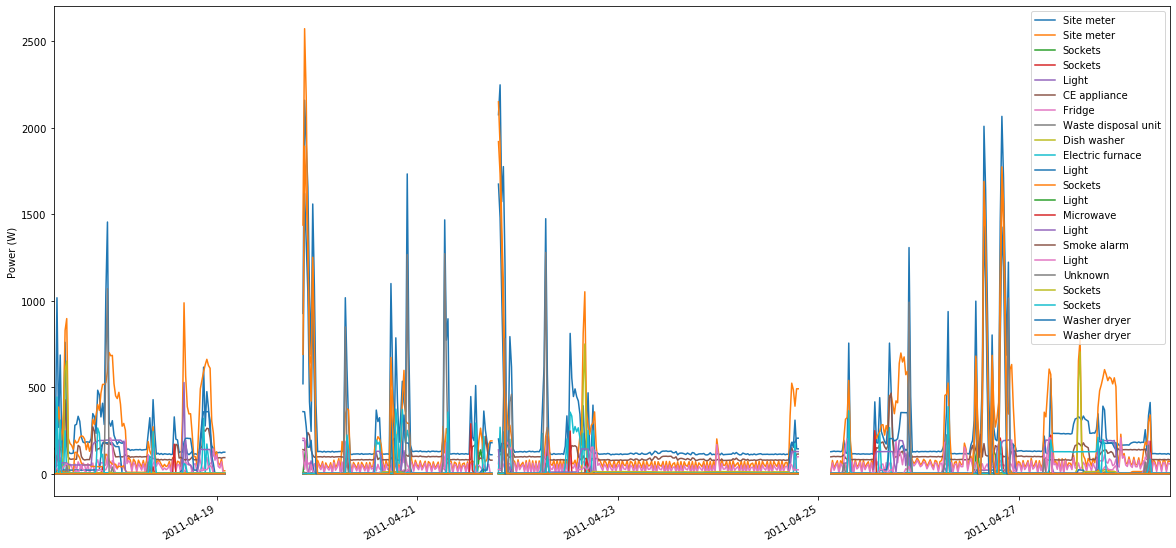

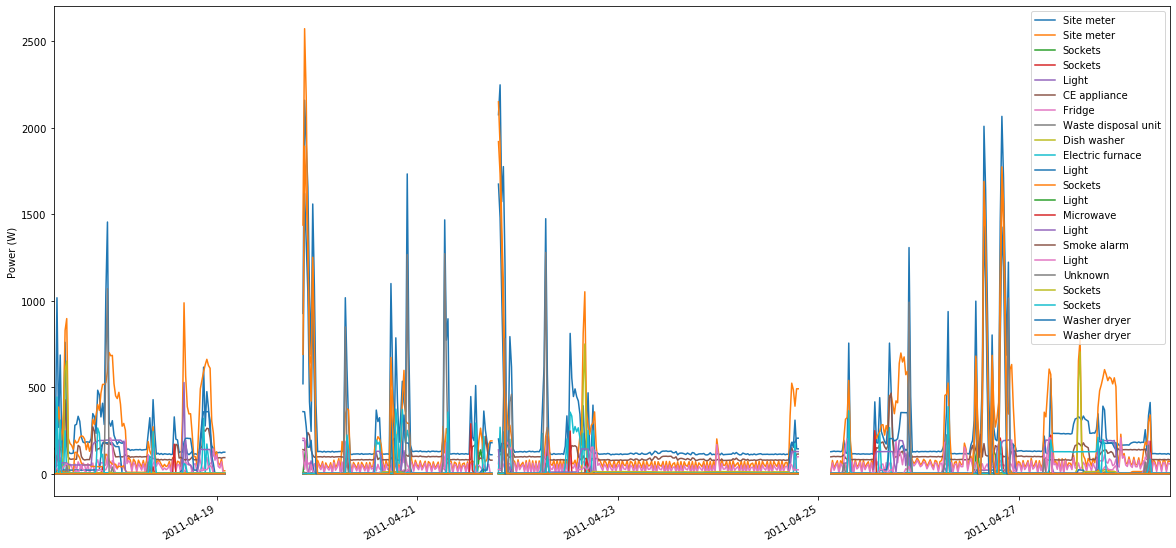

In [4]:
# Teste da classe
janelas_treino = Janelas(
    base=redd,
    id_residencia=3,
    inicio_intervalo='2011-04-16',
    fim_intervalo='2011-05-16',
    debug = False
)

janelas_teste = Janelas(
    base=redd,
    id_residencia=3,
    inicio_intervalo='2011-04-17',
    fim_intervalo='2011-04-30',
    debug = False
)


# Plots
fig = plt.figure(figsize=(20, 10))
print("TREINO - Consumo geral dos medidores/aparelhos no período:")
for m in range(len(janelas_treino.residencia.elec.meters)):
    janelas_treino.residencia.elec.meters[m].plot();

# Plots
fig = plt.figure(figsize=(20, 10))
print("TESTE - Consumo geral dos medidores/aparelhos no período:")
for m in range(len(janelas_teste.residencia.elec.meters)):
    janelas_teste.residencia.elec.meters[m].plot();

In [5]:
# Extrair series divididas em janelas para cada medidor
# a cada 90 segundos, em uma taxa de 3s
dados_cargas_treino = janelas_treino.preparar(taxa_amostral=3, intervalo_medicao=90)
dados_cargas_teste = janelas_teste.preparar(taxa_amostral=3, intervalo_medicao=90)

# Disposicao das janelas preparadas
pprint(dados_cargas_treino)

Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.
[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[125.265   , 125.43    , 124.26    , ..., 133.02667 , 128.81667 ,
        129.35    ],
       [129.51666 , 129.73334 , 129.06    , ..., 142.40334 , 146.25667 ,
        151.38666 ],
       [153.79666 , 151.71333 , 149.49667 , ..., 146.47    , 143.04333 ,
        142.67334 ],
       ...,
       [110.020004, 110.346664, 114.91667 , ..., 117.96333 , 117.19666 ,
        117.590004],
       [117.79    , 117.68667 , 116.87334 , ..., 110.32667 , 110.85667 ,
        110.706665],
       [110.369995, 110.57333 , 111.36667 , ..., 111.55666 , 111.56333 ,
        111.11    ]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': 

## Preparando Amostras (medidores residência ) e Rótulos (aparelhos)

In [6]:
# Listando as cargas que possuem janelas preparadas
janelas_treino.lista_cargas(dados_cargas_treino)

[(1, 'site_meter'),
 (2, 'site_meter'),
 (3, 'sockets'),
 (4, 'sockets'),
 (5, 'light'),
 (6, 'ce_appliance'),
 (7, 'fridge'),
 (8, 'waste_disposal_unit'),
 (9, 'dish_washer'),
 (10, 'electric_furnace'),
 (11, 'light'),
 (12, 'sockets'),
 (13, 'washer_dryer'),
 (14, 'washer_dryer'),
 (15, 'light'),
 (16, 'microwave'),
 (17, 'light'),
 (18, 'smoke_alarm'),
 (19, 'light'),
 (20, 'unknown')]

In [7]:
# Filtrando dados para conjunto de cargas
# NOTA: Os lares norte-americanos têm suprimentos de energia em fase dividida. 
#   Cada divisão é de 120 volts em relação ao neutro. As duas divisões 
#   totalizam 240 volts, por isso os dois 'site_meter'. 
#
#   Além disso, aparelhos que demandam energia (secadora, por exemplo) podem se 
#   conectar a ambas as divisões; na REDD se mede separadamente as duas divisões 
#   para esses tais aparelhos, contemplando no NILMTK dois medidores por 
#   dispositivo de 240 volts.

# Apenas duas fases da corrente eletrica da residencia
dados_medidores_treino = janelas_treino.filtrar_cargas(
    dados_cargas_treino,
    filtros=[
        (1, 'site_meter'),
        (2, 'site_meter'),    
    ]
)
print("Dados das janelas de ambos medidores da residência:")
print("---")
pprint(dados_medidores_treino)

print("\n\n")

# Apenas dados de aparelhos da residencia
dados_aparelhos_treino = janelas_treino.filtrar_cargas(
    dados_cargas_treino,
    filtros=[
        (3, 'sockets'),
        (4, 'sockets'),
        (5, 'light'),
        (6, 'ce_appliance'),
        (7, 'fridge'),
        (8, 'waste_disposal_unit'),
        (9, 'dish_washer'),
        (10, 'electric_furnace'),
        (11, 'light'),
        (12, 'sockets'),
        (13, 'washer_dryer'),
        (14, 'washer_dryer'),
        (15, 'light'),
        (16, 'microwave'),
        (17, 'light'),
        (18, 'smoke_alarm'),
        (19, 'light'),
        (20, 'unknown')
    ]
)
print("Dados das janelas dos aparelhos da residência:")
print("---")
pprint(dados_aparelhos_treino)

Dados das janelas de ambos medidores da residência:
---
[{'carga': 'site_meter',
  'instancia': 1,
  'janelas': array([[125.265   , 125.43    , 124.26    , ..., 133.02667 , 128.81667 ,
        129.35    ],
       [129.51666 , 129.73334 , 129.06    , ..., 142.40334 , 146.25667 ,
        151.38666 ],
       [153.79666 , 151.71333 , 149.49667 , ..., 146.47    , 143.04333 ,
        142.67334 ],
       ...,
       [110.020004, 110.346664, 114.91667 , ..., 117.96333 , 117.19666 ,
        117.590004],
       [117.79    , 117.68667 , 116.87334 , ..., 110.32667 , 110.85667 ,
        110.706665],
       [110.369995, 110.57333 , 111.36667 , ..., 111.55666 , 111.56333 ,
        111.11    ]], dtype=float32),
  'rotulos': {'estado': array([1, 1, 1, ..., 1, 1, 1]),
              'media': array([124.2916  , 139.66504 , 147.73633 , ..., 117.586555, 114.25255 ,
       111.034775], dtype=float32),
              'total': array([11186.244 , 12569.854 , 13296.27  , ..., 10582.79  , 10282.7295,
        9993.

In [8]:
# Janelas do medidores agregados
X = dados_medidores_treino[0]["janelas"] + dados_medidores_treino[1]["janelas"]

# Normalizando dados
# X = MinMaxScaler().fit_transform(X.T).T

print("* Dados dos medidores (Amostras / X):")
print("   - Shape:", X.shape)
print("   - Media:", np.mean(X))
print("   - Desvio:", np.std(X))

# Y = irá depender da carga a ser classificada

* Dados dos medidores (Amostras / X):
   - Shape: (3564, 90)
   - Media: 389.84167
   - Desvio: 681.469


In [9]:
# Verificar apenas janelas válidaso: com medicao total MAIOR QUE ZERO 
# (ou seja, amostras que possuam ao menos uma carga ativa - janelas zeradas
# são INÚTEIS para aprendizado do modelo, além de contribuir para desbalanceamento)
idx_janelas_validas = np.where(np.sum(X, axis=1)>0)[0]
print("* Janelas com TODOS aparelhos desligados: {} (~{:.1f}% das amostras)".format(
    X.shape[0] - len(idx_janelas_validas), 
    ( 1 - (len(idx_janelas_validas)/X.shape[0]) )*100 
))
print()

# AMOSTRAS -> Filtrando apenas JANELAS validas
X = X[idx_janelas_validas]
print("* Amostras validadas (X shape):", X.shape)
print()

# APARELHOS -> Filtrando apenas JANELAS validas
print("* Rotulos (estado) validados:")
for i in range(len(dados_aparelhos_treino)):
    
    dados_aparelhos_treino[i]["janelas"] = dados_aparelhos_treino[i]["janelas"][idx_janelas_validas]
    
    rotulos = copy.deepcopy(dados_aparelhos_treino[i]["rotulos"])
    
    dados_aparelhos_treino[i]["rotulos"]["estado"] = rotulos["estado"][idx_janelas_validas]
    dados_aparelhos_treino[i]["rotulos"]["media"]  = rotulos["media"][idx_janelas_validas]
    dados_aparelhos_treino[i]["rotulos"]["total"]  = rotulos["total"][idx_janelas_validas]
    print("   - `{}-{}`: {} -> {}".format(
        dados_aparelhos_treino[i]["carga"].upper(), dados_aparelhos_treino[i]["instancia"],
        Counter(rotulos["estado"]), 
        Counter(dados_aparelhos_treino[i]["rotulos"]["estado"])
    ))

* Janelas com TODOS aparelhos desligados: 400 (~11.2% das amostras)

* Amostras validadas (X shape): (3164, 90)

* Rotulos (estado) validados:
   - `SOCKETS-3`: Counter({0: 3514, 1: 50}) -> Counter({0: 3114, 1: 50})
   - `SOCKETS-4`: Counter({0: 3563, 1: 1}) -> Counter({0: 3163, 1: 1})
   - `LIGHT-5`: Counter({0: 3558, 1: 6}) -> Counter({0: 3158, 1: 6})
   - `CE_APPLIANCE-6`: Counter({1: 3162, 0: 402}) -> Counter({1: 3162, 0: 2})
   - `FRIDGE-7`: Counter({0: 1992, 1: 1572}) -> Counter({0: 1592, 1: 1572})
   - `WASTE_DISPOSAL_UNIT-8`: Counter({0: 3547, 1: 17}) -> Counter({0: 3147, 1: 17})
   - `DISH_WASHER-9`: Counter({0: 3515, 1: 49}) -> Counter({0: 3115, 1: 49})
   - `ELECTRIC_FURNACE-10`: Counter({0: 3447, 1: 117}) -> Counter({0: 3047, 1: 117})
   - `LIGHT-11`: Counter({0: 2754, 1: 810}) -> Counter({0: 2354, 1: 810})
   - `SOCKETS-12`: Counter({0: 3182, 1: 382}) -> Counter({0: 2782, 1: 382})
   - `WASHER_DRYER-13`: Counter({0: 3471, 1: 93}) -> Counter({0: 3071, 1: 93})
   - `WASHER_D

In [10]:
# TOP-5 aparelhos com maior consumo
top_aparelhos_consumo = []
for m in janelas_treino.residencia.elec.submeters().select_top_k(5).meters:
    instancia = m.instance()
    carga = m.label().lower().replace(" ","_")
    if type(instancia)==tuple and len(instancia) > 1:
        for i in instancia:
            top_aparelhos_consumo.append((i, carga))
    else:
        top_aparelhos_consumo.append((instancia, carga))
        
print("\n")
print("------------------------------------------------------------------")
print("* Top-5 aparelhos com maior consumo total de energia no intervalo:")
print("------------------------------------------------------------------")
pprint(top_aparelhos_consumo)
print("----------------------------------------------")

19/19 MeterGroup(meters==22, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=5)])1)])1)])])
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=14, building=3, dataset='REDD') ...   

------------------------------------------------------------------
* Top-5 aparelhos com maior consumo total de energia no intervalo:
------------------------------------------------------------------
[(6, 'ce_appliance'),
 (13, 'washer_dryer'),
 (14, 'washer_dryer'),
 (7, 'fridge'),
 (17, 'light'),
 (11, 'light')]
----------------------------------------------


**Distribuções dos estados (rótulos classificação):**

   - `CE_APPLIANCE-6`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {1: 3162, 0: 2}
   - `WASHER_DRYER-13`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 3071, 1: 93}
   - `WASHER_DRYER-14`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 3031, 1: 133}
   - `FRIDGE-7`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 1592, 1: 1572}
   - `LIGHT-17`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 2243, 1: 921}
  
   - `LIGHT-11`&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;: {0: 2354, 1: 810}
   
   
<u>**CONCLUSÕES PARCIAIS:**</u>
1. É possível perceber que o aparelho `CE_APPLIANCE-6` é inviável de treinar nestas configurações, pois há apenas amostras positivas;
2. `FRIDGE-7` é o aparelho com melhor equlibrio de amostras, ou seja, possui menor grau de desbalanceamento;
3. De resto, todos os aparelhos possuem grande desbalanceamento; `talvez seja necessário avaliar individualmente o tamanho da janela considerada para cada aparelho`.
    * Corrobora [Fagiani *et. al* (2019)](https://www.mdpi.com/1996-1073/12/7/1371), os quais afirmam que *"(...) geralmente, apesar da tarefa a ser resolvida dependendo da formulação do algoritmo, a precisão da desagregação diminui proporcionalmente com a variação da taxa de amostragem."*

Portanto, vamos considerar avaliar diferentes 'sample rate' em um pipeline de classificação (RP+CNN) comum neste estudo, considerando as cargas de maior consumo.

In [11]:
# Eletrônicos, Luzes, refrigerador, lava loucas, aquecedor, secadora de
# roupas, alarmes de incêndio, equipamentos de banheiro, utensílios de
# cozinha, Micro-ondas, utensílios externos.

In [12]:
# # TOP-5 aparelhos com maior DEMANDA de energia
# df_energia = janelas.residencia.elec.dataframe_of_meters()

# fig = plt.figure(figsize=(20,8))
# cargas = janelas.residencia.elec.get_labels(df_energia.columns)[2:]
# legenda = []
# dados_energia = [] # Lista com estatisticas por caga
# for i, coluna in enumerate(df_energia.columns[2:]):
#     instancia = ""
#     if hasattr(coluna, "instance"):
#         instancia = coluna.instance
#     else:
#         instancia = tuple([m.instance for m in coluna.meters])

#     serie = np.nan_to_num(df_energia[coluna].values)
#     dados_energia.append({
#         "carga": cargas[i],
#         "instancia": instancia,
#         "total": np.sum(serie),
#         "maximo": np.max(serie),
#         "minimo": np.min(serie),
#         "media": np.mean(serie),
#         "desvio": np.std(serie)
#     })
#     legenda.append(f"{cargas[i]}-{str(instancia)}")
#     plt.plot(np.arange(df_energia.shape[0]), serie)
# plt.legend(legenda);
# plt.title("Consumo por Dispositivo dentro do Intervalo")
# plt.show();

# sorted(dados_energia, key=lambda k: k['maximo'], reverse=False) 

## Transformar Séries (Janelas) em Imagens

In [13]:

# fig, axes = plt.subplots(1,4, figsize=(20,5))

# axes[0].plot(np.arange(len(X[3])), X[3])
# axes[0].set_title("Série Original (Janela)")
# # axes[0].grid(False)

# # RPs
# X_rp = RecurrencePlot().fit_transform(X)
# axes[1].imshow(X_rp[3], cmap="plasma");
# axes[1].set_title("RP")
# axes[1].grid(False)

# # GASF
# X_gasf = GramianAngularField(method="summation").fit_transform(X)
# axes[2].imshow(X_gasf[3], cmap="plasma");
# axes[2].set_title("GASF")
# axes[2].grid(False)

# # GASF
# X_gadf = GramianAngularField(method="difference").fit_transform(X)
# axes[3].imshow(X_gadf[3], cmap="plasma");
# axes[3].set_title("GADF")
# axes[3].grid(False)

# # # MTF
# # X_mtf = MarkovTransitionField().fit_transform(X[np.where(np.sum(X, axis=1)>0)[0]])
# # plt.imshow(X_mtf[3], cmap="plasma");
# # plt.title("MTF")
# # plt.grid(False)
# # plt.show()
# plt.show()

# # Gerando imagens RGB N canais
# X_imagem = np.stack([X_rp, X_gasf, X_gadf], axis=-1)
# print("* Shape da matriz de amostras:", X_imagem.shape)

# Modelagem

In [14]:
# from PyNILM.dados.janelas import Janelas

from PyNILM.avaliacao.metricas import *
from PyNILM.avaliacao.graficos import *
from PyNILM.avaliacao.analises import *

from sklearn.model_selection import train_test_split

from pyts.image import RecurrencePlot
import cv2

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPool1D
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras import backend as K
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


from pyts.image import RecurrencePlot, GramianAngularField

# Garantindo reprodutibilidade
import random as rn
# Constantes dos experimentos
SEED = 33
FRACAO_TESTE = 0.25
EPOCAS = 100
TAMANHO_LOTE = 32
VERBOSIDADE = 0
PARAMETROS_RP = {
    "dimension": 1,
    "time_delay": 1,
    "threshold": None,
    "percentage": 10
}
TAMANHO_IMAGEM = (32, 32) # Apenas 1 canal
# PARAMETROS_RP={
#     "dimension": 3,
#     "time_delay": 8,
#     "threshold": 0.1
# }
# Travar Seed's
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(SEED)
rn.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
tf.random.set_seed(SEED)

# Habilitando/limitando utilização de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*5)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("# GPUs habilitadas:", "{} física(s)".format(len(gpus)), "/", "{} lógica(s)".format(len(gpus)))
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
        
def convnet(
    input_shape_ = (30, 30, 1), 
    output_dim=6, 
    loss_function = 'binary_crossentropy', 
    metrics=['accuracy'],
    output_activation = 'softmax'
):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=input_shape_))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(output_dim, activation=output_activation))

    model.compile(optimizer='adam', loss=[loss_function], metrics=metrics)
    
    return model

In [15]:
# Verificando caracteristicas de funcionamento dos aparelhos
def repeticao_maxima_valor(vetor, valor = True):
    mask = np.concatenate(([False], vetor == valor,[False]))
    if ~mask.any():
        return 0
    else:
        idx = np.nonzero(mask[1:] != mask[:-1])[0]
        return (idx[1::2] - idx[::2]).max()
    
print("* Verificando caracteristicas de funcionamento dos aparelhos:")
print()
min_on, max_on = [], []
min_off, max_off = [], []

# janelas = Janelas(
#     base=redd,
#     id_residencia=3,
#     inicio_intervalo='2011-04-16 05:11:30',
#     fim_intervalo='2011-04-23 08:43:26',
#     debug = False
# )

for e in janelas_treino.residencia.elec.meters:
    status = when_on = next(e.when_on())
    intervalo_maximo_on = repeticao_maxima_valor(status, True)
    intervalo_maximo_off = repeticao_maxima_valor(status, False)
    print(" -", e.label()+" - "+str(e.instance())+":")
    print("   -> ON (acionado) = Duração mínima:", e.min_on_duration(), "/ Duração máxima:", intervalo_maximo_on)
    print("   -> OFF (desligado) = Duração mínima:", e.min_off_duration(), "/ Duração máxima:", intervalo_maximo_off)
    
    min_on.append(e.min_on_duration())
    max_on.append(intervalo_maximo_on)
    
    min_off.append(e.min_off_duration())
    max_off.append(intervalo_maximo_off)
    print()
    
print()
print("-----")
print("Resultados:")
print()
print("* Periodos ON:")
print("  -> Mínimo:", sorted(list(set(min_on))))
print("  -> Máximo:", sorted(list(set(max_on))))
print()
print("* Periodos OFF:")
print("  -> Mínimo:", sorted(list(set(min_off))))
print("  -> Máximo:", sorted(list(set(max_off))))

* Verificando caracteristicas de funcionamento dos aparelhos:

 - Site meter - 1:
   -> ON (acionado) = Duração mínima: 0 / Duração máxima: 795967
   -> OFF (desligado) = Duração mínima: 0 / Duração máxima: 0

 - Site meter - 2:
   -> ON (acionado) = Duração mínima: 0 / Duração máxima: 795967
   -> OFF (desligado) = Duração mínima: 0 / Duração máxima: 0

 - Sockets - 3:
   -> ON (acionado) = Duração mínima: 20 / Duração máxima: 167
   -> OFF (desligado) = Duração mínima: 20 / Duração máxima: 79891

 - Sockets - 4:
   -> ON (acionado) = Duração mínima: 20 / Duração máxima: 1
   -> OFF (desligado) = Duração mínima: 20 / Duração máxima: 80665

 - Light - 5:
   -> ON (acionado) = Duração mínima: 20 / Duração máxima: 232
   -> OFF (desligado) = Duração mínima: 20 / Duração máxima: 191700

 - CE appliance - 6:
   -> ON (acionado) = Duração mínima: 20 / Duração máxima: 219248
   -> OFF (desligado) = Duração mínima: 20 / Duração máxima: 0

 - Fridge - 7:
   -> ON (acionado) = Duração mínima: 2

In [16]:
# Intervalos possiveis (de acordo com funcionamento das cargas)
janelas_avaliacao = np.array(sorted(list(set(min_on+max_on))))

# Janelas de avaliações consideradas na otimização
janelas_avaliacao = janelas_avaliacao[np.where( (janelas_avaliacao > 5) & (janelas_avaliacao <= 2347))[0]]
janelas_avaliacao

array([  20,   45,  167,  232,  264,  283,  600,  622,  936, 1912, 2347],
      dtype=int64)

In [17]:
# Executar otimização (espaço de busca taxa / janela)
DEBUG = True

if not os.path.isfile(os.path.join(caminho_dados_notebook, 'resultados_taxa-amostragem_janelas.csv')):
    # Cenarios de avaliacao:
    # ---
    resultados = {
        "carga": [],
        "taxa_amostragem": [],
        "janela": [],
        "loss": [],
        "acuracia": [],
        "precisao": [],
        "recall": [],
        "f1": [],
        "f1_macro": []
    }

    # Intervalo de tempo e residencia considerados na base REDD
    # UPDATE: Treinando com dados completos
#     janelas = Janelas(
#         base=redd,
#         id_residencia=3,
#         inicio_intervalo='2011-04-16',
#         fim_intervalo='2011-05-30',
#         debug = False
#     )
    # UPDATE: treinando com dados de treino amplo
    janelas = janelas_treino

    # Testar diferentes taxas de amostragem
    taxas_amostragem = [2,3,4,5]
    for taxa in taxas_amostragem:
        
        for janela in [30, 60, 90, 180, 360, 540, 720, 900, 1080]: # nao foi possivel devido ao limite modelo/GPU
#         for janela in janelas_avaliacao:
            
            janela = int(janela)
            print()
            print("-="*10, f"AMOSTRAGEM `{taxa}s` / JANELA `{janela}`", "=-"*10)
            print()

            # Extrair series divididas em janelas para cada medidor
            if DEBUG: print("* Preparando dados das janelas para a taxa de amostragem...")
            # TODO: corrigir output com counter duplicados
            dados_cargas = janelas.preparar(
                taxa_amostral = taxa, 
                intervalo_medicao= janela 
            )
            if DEBUG: print()

            # Apenas duas fases da corrente eletrica da residencia
            if DEBUG: print("* Dividindo cargas entre medidores (mains) e aparelhos...")
            dados_medidores = janelas.filtrar_cargas(
                dados_cargas,
                filtros=[
                    (1, 'site_meter'),
                    (2, 'site_meter'),    
                ]
            )
            # Apenas dados de aparelhos da residencia
            dados_aparelhos = janelas.filtrar_cargas(
                dados_cargas,
                filtros=[
#                     (3, 'sockets'),
#                     (4, 'sockets'),
#                     (5, 'light'),
#                     (6, 'ce_appliance'),
                    (7, 'fridge'),
#                     (8, 'waste_disposal_unit'),
                    (9, 'dish_washer'),
#                     (10, 'electric_furnace'),
#                     (11, 'light'),
#                     (12, 'sockets'),
                    (13, 'washer_dryer'),
                    (14, 'washer_dryer'),
#                     (15, 'light'),
                    (16, 'microwave'),
#                     (17, 'light'),
#                     (18, 'smoke_alarm'),
#                     (19, 'light'),
#                     (20, 'unknown')
                ]
            )

            # <<< Limpando memoria >>>
            dados_cargas = None
            del dados_cargas
            gc.collect()
            # <<< Limpando memoria >>>

            if DEBUG: print()

            # Gerar matriz de amostras do modelo (X) e preparar rotulos Y (estado das cargas)
            if DEBUG: print("* Preparando amostras e rótulos...")

            # Validar tamanho dos dados de medidores (podem ter mais registros que os aparelhos)
            janela_media_medidores = int(np.sum([len(d["janelas"])for d in dados_medidores])/len(dados_medidores))
            janela_media_aparelhos = int(np.sum([len(d["janelas"])for d in dados_aparelhos])/len(dados_aparelhos))

            # Ajustando para medidores terem o mesmo shape de janelas dos aparelhos 
            if janela_media_medidores > janela_media_aparelhos:
                diferenca = janela_media_medidores-janela_media_aparelhos
                if DEBUG: print("  -> Diferenca encontrada entre medidores/aparelhos:", diferenca, ", ajustando..")
                for i in range(len(dados_medidores)):
                    removidos = 0
                    while removidos < diferenca:
                        # Remover ultima janela
                        dados_medidores[i]["janelas"] = dados_medidores[i]["janelas"][:-1,:]
                        removidos += 1


            X = dados_medidores[0]["janelas"] + dados_medidores[1]["janelas"]

            # <<< Limpando memoria >>>
            dados_medidores = None
            del dados_medidores
            gc.collect()
            # <<< Limpando memoria >>>

            # Normalizacao dos dados (DESUSO)
            #X = MinMaxScaler().fit_transform(X.T).T # Normalizando dados

            # Selecionando apenas janelas VALIDAS (ocorrencia de ao menos 1 carga)
            # TODO: Implementar na biblioteca esta rotina de validacao
            idx_janelas_validas = np.where(np.sum(X, axis=1)>0)[0]
            X = X[idx_janelas_validas]
            for i in range(len(dados_aparelhos)):
                dados_aparelhos[i]["janelas"] = dados_aparelhos[i]["janelas"][idx_janelas_validas]
                rotulos = copy.deepcopy(dados_aparelhos[i]["rotulos"])
                dados_aparelhos[i]["rotulos"]["estado"] = rotulos["estado"][idx_janelas_validas]
                dados_aparelhos[i]["rotulos"]["media"]  = rotulos["media"][idx_janelas_validas]
                dados_aparelhos[i]["rotulos"]["total"]  = rotulos["total"][idx_janelas_validas]
                if DEBUG:
                    print("   - `{}-{}`: {} => {}".format(
                        dados_aparelhos[i]["carga"].upper(), 
                        dados_aparelhos[i]["instancia"],
                        Counter(rotulos["estado"]),
                        Counter(dados_aparelhos[i]["rotulos"]["estado"])
                    ))
            if DEBUG: print()

            ################### PRÉ-PROCESSAMENTO DAS IMAGENS ###################
            # TODO: Implamentar na PyNILM

            # Transformacao das series/janelas em imagens (RPs)...
            try:
                if DEBUG: print("* Transformando séries (amostras) em imagens...");print()
                X_imagem = RecurrencePlot().set_params(**PARAMETROS_RP).fit_transform(X)

                # <<< Limpando memoria >>>
                X = None
                del X
                gc.collect()

                # DEBUG: Plotar imagens
                #X_imagem_original = X_imagem[0].astype(np.float32)

                # Redimensionando imagem (de acordo com o definido, considerando 
                # apenas 1 CANAL - complexidade computacional)
                if DEBUG: print("* Redimensionando imagens {} -> {}".format(X_imagem[0].shape, TAMANHO_IMAGEM));print()
                X_imagem = np.stack([
                    [cv2.resize(
                        imagem, 
                        dsize=TAMANHO_IMAGEM, 
                        interpolation=cv2.INTER_CUBIC).astype(np.float16) \
                        for imagem in tqdm_notebook(X_imagem)]
                ], axis=-1).astype(np.float16) 


                ## DEBUG: Plotar imagens
                #print(" - X_imagem shape processado:", X_imagem.shape)
                #fig, axes = plt.subplots(1,2,figsize=(15,15))
                #axes[0].imshow(X_imagem_original, cmap='viridis')
                #axes[0].set_title("Imagem original (Shape = {})".format(X_imagem_original.shape))
                #axes[0].grid(False)
                #X_imagem_resized = cv2.resize(X_imagem_original, dsize=TAMANHO_IMAGEM, interpolation=cv2.INTER_CUBIC)
                #axes[1].imshow(X_imagem[0,:,:,0].astype(np.float32), cmap='viridis')
                #axes[1].set_title("Imagem redimensionada (Shape = {})".format(X_imagem_resized.shape))
                #axes[1].grid(False)
                #plt.show()

                ################### PRÉ-PROCESSAMENTO DAS IMAGENS ###################
                if DEBUG: print("  -> Shape da matriz de amostras:", X_imagem.shape); print()

                # Loop sobre TODOS os aparelhos (binarios, parametros similares estudo ja feito)
                if DEBUG: print("* Avaliando modelos binários para cada um dos aparelhos, aguarde..."); print()
                for aparelho in dados_aparelhos:
                    caminho_persistencia_resultados = os.path.join(
                        caminho_imagens_notebook, 
                        'taxa-{}_janela-{}_{}'.format(
                            taxa, janela, f'{aparelho["carga"]}-{aparelho["instancia"]}' 
                        )
                    )
                    if not os.path.isdir(caminho_persistencia_resultados):
                        try:
                            print("-"*50)
                            print()

                            y = aparelho["rotulos"]["estado"]

                            if DEBUG: print(f"_ Dados do aparelho `{aparelho['carga'].upper()} - {aparelho['instancia']}` (Y / rótulo:)")
                            if DEBUG: print("   - ", Counter(y)); print()

                            # Split de treino / teste
                            if DEBUG: print("_ Treinando o modelo classificador de estados...")

                            estratificacao = y
                            # Ver se é inviavel estratificacao
                            for v in Counter(y).values():
                                if v == 1:
                                    estratificacao = None
                                    break
                            X_treino, X_teste, y_treino, y_teste = train_test_split(
                                X_imagem, y,
                                test_size=FRACAO_TESTE,
                                stratify=estratificacao,
                                random_state=SEED
                            )

                            # Treinando modelo
                            modelo = convnet(
                                input_shape_= X_imagem[0,:,:].shape,
                                output_dim = 1,
                                loss_function='binary_crossentropy',
                                metrics=['accuracy'],
                                output_activation='sigmoid'
                            )

                            historico = modelo.fit(
                                X_treino, y_treino,
                                validation_data=(X_teste, y_teste),
                                epochs=EPOCAS,
                                batch_size=TAMANHO_LOTE,
                                verbose=VERBOSIDADE
                            )

                            print()

                            # Resultados do modelo
                            r = modelo.evaluate(X_teste, y_teste)

                            # TODO: implementar opção de apenas salvar imagens na pasta
                            #   do notebook ao inves de exibi-las no IPython notebook
                            #   padrao -> os.path.join(CAMINHO_IMAGENS_NOTEBOOK, 'taxa-{}.janela-{}_convergencia-loss.png'.format(taxa, janela))
                            # ---                 
                            # Avaliando modelo
                            relatorio_classificacao_aparelho(
                                modelo, X_teste, y_teste, 
                                f'{aparelho["carga"]} - {aparelho["instancia"]}',
                                caminho_persistencia=caminho_persistencia_resultados
                            )

                            # Considerando resultados adicionais da analise
                            df_resultados = pd.read_csv(
                                os.path.join(
                                    caminho_persistencia_resultados,
                                    "resultados_analise.csv"
                                )
                            )

                            # Incluindo dados no dataframe
                            resultados["carga"].append(f'{aparelho["carga"]} - {aparelho["instancia"]}')
                            resultados["taxa_amostragem"].append(taxa)
                            resultados["janela"].append(janela)
                            resultados["loss"].append(r[0])
                            resultados["acuracia"].append(r[1])
                            resultados["precisao"].append(df_resultados["Precisão"].values[0])
                            resultados["recall"].append(df_resultados["Recall"].values[0])
                            resultados["f1"].append(df_resultados["F1-score"].values[0])
                            resultados["f1_macro"].append(df_resultados["F1-macro"].values[0])

                            # Persistindo o log individual do modelo (backup)
                            if not os.path.isdir(os.path.join(caminho_persistencia_resultados)):
                                os.makedirs(caminho_persistencia_resultados)
                            with open(os.path.join(caminho_persistencia_resultados, "resultados_modelo.log"), "w") as log:
                                log.write(
                                    "{},{},{},{},{}".format(
                                        f'{aparelho["carga"]} - {aparelho["instancia"]}',
                                        taxa,
                                        janela,
                                        r[0],
                                        r[1]
                                    )
                                )

                            print()

                        except Exception as e:
                            print(f" !# Não foi possível treinar o modelo para a combinação de taxa `{str(taxa)}` / janela `{str(janela)}`: {str(e)}")
                    else:
                        print(f" !# Modelo já treinado para a combinação de carga `{aparelho['carga']}-{aparelho['instancia']}` / taxa `{str(taxa)}` / janela `{str(janela)}`")
                        print()

                        # Considerando resultados adicionais da analise
                        df_resultados = pd.read_csv(
                            os.path.join(
                                caminho_persistencia_resultados,
                                "resultados_analise.csv"
                            ),
                        )

                        # Lendo resultados dos logs
                        with open(os.path.join(caminho_persistencia_resultados, "resultados_modelo.log"), "r") as log:
                            dados = log.readlines()[0].split(',')
                            resultados["carga"].append(dados[0])
                            resultados["taxa_amostragem"].append(int(dados[1]))
                            resultados["janela"].append(int(dados[2]))
                            resultados["loss"].append(float(dados[3]))
                            resultados["acuracia"].append(round(float(dados[4]),7))
                            resultados["precisao"].append(df_resultados["Precisão"].values[0])
                            resultados["recall"].append(df_resultados["Recall"].values[0])
                            resultados["f1"].append(df_resultados["F1-score"].values[0])
                            resultados["f1_macro"].append(df_resultados["F1-macro"].values[0])

                # <<< Limpando memoria >>>
                X_imagem = None
                del X_imagem
                dados_aparelhos = None
                del dados_aparelhos
                gc.collect()
                # <<< Limpando memoria >>>

                print()
                
            except Exception as e:
                print("# ERRO:", str(e))
                
    # Exportar resultados
    df_resultados = pd.DataFrame(resultados)
    df_resultados.to_csv(os.path.join(caminho_dados_notebook, "resultados_taxa-amostragem_janelas.csv"))
                              
else:
    print("####################################")
    print(f"#          A T E N Ç Ã O           #")
    print("####################################")
    print("\nExecução já realizada anteriormente.")
    print(f"\nOs resultados estão disponíveis no arquivo \n`{os.path.join(caminho_dados_notebook,'resultados_taxa-amostragem_janelas.csv')}`")
    print("\n####################################")


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `30` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({0: 10460, 1: 5579}) => Counter({0: 8588, 1: 5573})
   - `DISH_WASHER-9`: Counter({0: 15848, 1: 191}) => Counter({0: 13970, 1: 191})
   - `WASHER_DRYER-13`: Counter({0: 15725, 1: 314}) => Counter({0: 13847, 1: 314})
   - `WASHER_DRYER-14`: Counter({0: 15485, 1: 554}) => Counter({0: 13607, 1: 554})
   - `MICROWAVE-16`: Counter({0: 15924, 1: 115}) => Counter({0: 14046, 1: 115})

* Transformando séries (amostras) em imagens...

* Redimensionando imagens (30, 30) -> (32, 32)



  0%|          | 0/14161 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (14161, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 8588, 1: 5573})

_ Treinando o modelo classificador de estados...

111/111 [==============================] - 0s 4ms/step - loss: 0.5199 - accuracy: 0.7167
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,71.67
Precisão,59.88
Recall,85.01
F1-score,70.26
F1-macro,71.61
Hamming Loss,0.28
AUC,0.74
Suporte (y=0),2147.00
Suporte (y=1),1394.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:
Instructions for updating:
Please use `model.predict()` instead.

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 13970, 1: 191})

_ Treinando o modelo classificador de estados...

111/111 [==============================] - 0s 4ms/step - loss: 0.0906 - accuracy: 0.9850
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.50
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.62
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),3493.00
Suporte (y=1),48.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 13847, 1: 314})

_ Treinando o modelo classificador de estados...

111/111 [==============================] - 0s 4ms/step - loss: 0.0347 - accuracy: 0.9884
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.84
Precisão,88.00
Recall,55.70
F1-score,68.22
F1-macro,83.81
Hamming Loss,0.01
AUC,0.78
Suporte (y=0),3462.00
Suporte (y=1),79.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 13607, 1: 554})

_ Treinando o modelo classificador de estados...

111/111 [==============================] - 0s 4ms/step - loss: 0.0879 - accuracy: 0.9720
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.20
Precisão,67.54
Recall,55.40
F1-score,60.87
F1-macro,79.71
Hamming Loss,0.03
AUC,0.77
Suporte (y=0),3402.00
Suporte (y=1),139.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 14046, 1: 115})

_ Treinando o modelo classificador de estados...

111/111 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.9912
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.12
Precisão,25.00
Recall,3.45
F1-score,6.06
F1-macro,52.81
Hamming Loss,0.01
AUC,0.52
Suporte (y=0),3512.00
Suporte (y=1),29.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `30`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({0: 5006, 1: 3013}) => Counter({0: 4087, 1: 3012})
   - `DISH_WASHER-9`: Counter({0: 7920, 1: 99}) => Counter({0: 7000, 1: 99})
   - `WASHER_DRYER-13`: Counter({0: 7832, 1: 187}) => Counter({0: 6912, 1: 187})
   - `WASHER_DRYER-14`: Counter({0: 7737, 1: 282}) => Counter({0: 6817, 1: 282})
   - `MICROWAVE-16`: Counter({0: 7950, 1: 69}) => Counter({0: 7030, 1: 69})

* Transformando séries (amostras) em image

  0%|          | 0/7099 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (7099, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 4087, 1: 3012})

_ Treinando o modelo classificador de estados...

56/56 [==============================] - 0s 5ms/step - loss: 0.7484 - accuracy: 0.7346
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,73.46
Precisão,67.94
Recall,70.92
F1-score,69.40
F1-macro,72.99
Hamming Loss,0.27
AUC,0.73
Suporte (y=0),1022.00
Suporte (y=1),753.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 7000, 1: 99})

_ Treinando o modelo classificador de estados...

56/56 [==============================] - 0s 4ms/step - loss: 0.6524 - accuracy: 0.9848
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.48
Precisão,25.00
Recall,4.00
F1-score,6.90
F1-macro,53.06
Hamming Loss,0.02
AUC,0.52
Suporte (y=0),1750.00
Suporte (y=1),25.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 6912, 1: 187})

_ Treinando o modelo classificador de estados...

56/56 [==============================] - 0s 5ms/step - loss: 0.0069 - accuracy: 0.9989
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.89
Precisão,100.00
Recall,95.74
F1-score,97.83
F1-macro,98.88
Hamming Loss,0.00
AUC,0.98
Suporte (y=0),1728.00
Suporte (y=1),47.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 6817, 1: 282})

_ Treinando o modelo classificador de estados...

56/56 [==============================] - 0s 4ms/step - loss: 0.0780 - accuracy: 0.9803
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,98.03
Precisão,97.37
Recall,52.11
F1-score,67.89
F1-macro,83.44
Hamming Loss,0.02
AUC,0.76
Suporte (y=0),1704.00
Suporte (y=1),71.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 7030, 1: 69})

_ Treinando o modelo classificador de estados...

56/56 [==============================] - 0s 4ms/step - loss: 0.0425 - accuracy: 0.9904
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.04
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.76
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1758.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `60`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({0: 3195, 1: 2151}) => Counter({0: 2588, 1: 2151})
   - `DISH_WASHER-9`: Counter({0: 5277, 1: 69}) => Counter({0: 4670, 1: 69})
   - `WASHER_DRYER-13`: Counter({0: 5214, 1: 132}) => Counter({0: 4607, 1: 132})
   - `WASHER_DRYER-14`: Counter({0: 5154, 1: 192}) => Counter({0: 4547, 1: 192})
   - `MICROWAVE-16`: Counter({0: 5289, 1: 57}) => Counter({0: 4682, 1: 57})

* Transformando séries (amostras) em image

  0%|          | 0/4739 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (4739, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 2588, 1: 2151})

_ Treinando o modelo classificador de estados...

38/38 [==============================] - 0s 4ms/step - loss: 0.5430 - accuracy: 0.7409
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,74.09
Precisão,66.67
Recall,85.87
F1-score,75.06
F1-macro,74.05
Hamming Loss,0.26
AUC,0.75
Suporte (y=0),647.00
Suporte (y=1),538.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 4670, 1: 69})

_ Treinando o modelo classificador de estados...

38/38 [==============================] - 0s 4ms/step - loss: 0.0925 - accuracy: 0.9857
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.57
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.64
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1168.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 4607, 1: 132})

_ Treinando o modelo classificador de estados...

38/38 [==============================] - 0s 4ms/step - loss: 0.0443 - accuracy: 0.9924
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.24
Precisão,92.86
Recall,78.79
F1-score,85.25
F1-macro,92.43
Hamming Loss,0.01
AUC,0.89
Suporte (y=0),1152.00
Suporte (y=1),33.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 4547, 1: 192})

_ Treinando o modelo classificador de estados...

38/38 [==============================] - 0s 4ms/step - loss: 0.1383 - accuracy: 0.9755
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.55
Precisão,100.00
Recall,39.58
F1-score,56.72
F1-macro,77.73
Hamming Loss,0.02
AUC,0.70
Suporte (y=0),1137.00
Suporte (y=1),48.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 4682, 1: 57})

_ Treinando o modelo classificador de estados...

38/38 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.9865
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.66
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1171.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `90`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({0: 1394, 1: 1279}) => Counter({1: 1279, 0: 1097})
   - `DISH_WASHER-9`: Counter({0: 2634, 1: 39}) => Counter({0: 2337, 1: 39})
   - `WASHER_DRYER-13`: Counter({0: 2604, 1: 69}) => Counter({0: 2307, 1: 69})
   - `WASHER_DRYER-14`: Counter({0: 2571, 1: 102}) => Counter({0: 2274, 1: 102})
   - `MICROWAVE-16`: Counter({0: 2636, 1: 37}) => Counter({0: 2339, 1: 37})

* Transformando séries (amostras) em imagen

  0%|          | 0/2376 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (2376, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 1279, 0: 1097})

_ Treinando o modelo classificador de estados...

19/19 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.7492
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,74.92
Precisão,80.87
Recall,70.00
F1-score,75.04
F1-macro,74.92
Hamming Loss,0.25
AUC,0.75
Suporte (y=0),274.00
Suporte (y=1),320.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 2337, 1: 39})

_ Treinando o modelo classificador de estados...

19/19 [==============================] - 0s 4ms/step - loss: 0.2330 - accuracy: 0.9832
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.32
Precisão,50.00
Recall,10.00
F1-score,16.67
F1-macro,57.91
Hamming Loss,0.02
AUC,0.55
Suporte (y=0),584.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 2307, 1: 69})

_ Treinando o modelo classificador de estados...

19/19 [==============================] - 0s 4ms/step - loss: 0.0706 - accuracy: 0.9899
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.99
Precisão,92.31
Recall,70.59
F1-score,80.00
F1-macro,89.74
Hamming Loss,0.01
AUC,0.85
Suporte (y=0),577.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 2274, 1: 102})

_ Treinando o modelo classificador de estados...

19/19 [==============================] - 0s 3ms/step - loss: 0.1686 - accuracy: 0.9663
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.63
Precisão,61.90
Recall,52.00
F1-score,56.52
F1-macro,77.39
Hamming Loss,0.03
AUC,0.75
Suporte (y=0),569.00
Suporte (y=1),25.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 2339, 1: 37})

_ Treinando o modelo classificador de estados...

19/19 [==============================] - 0s 4ms/step - loss: 0.3126 - accuracy: 0.9781
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,97.81
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.45
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),585.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `180`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 822, 0: 514}) => Counter({1: 822, 0: 371})
   - `DISH_WASHER-9`: Counter({0: 1313, 1: 23}) => Counter({0: 1170, 1: 23})
   - `WASHER_DRYER-13`: Counter({0: 1297, 1: 39}) => Counter({0: 1154, 1: 39})
   - `WASHER_DRYER-14`: Counter({0: 1281, 1: 55}) => Counter({0: 1138, 1: 55})
   - `MICROWAVE-16`: Counter({0: 1303, 1: 33}) => Counter({0: 1160, 1: 33})

* Transformando séries (amostras) em imagens...


  0%|          | 0/1193 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (1193, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 822, 0: 371})

_ Treinando o modelo classificador de estados...

10/10 [==============================] - 0s 3ms/step - loss: 0.9404 - accuracy: 0.8227
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,82.27
Precisão,90.05
Recall,83.50
F1-score,86.65
F1-macro,80.14
Hamming Loss,0.18
AUC,0.82
Suporte (y=0),93.00
Suporte (y=1),206.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1170, 1: 23})

_ Treinando o modelo classificador de estados...

10/10 [==============================] - 0s 3ms/step - loss: 0.2131 - accuracy: 0.9732
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.32
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.32
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),293.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1154, 1: 39})

_ Treinando o modelo classificador de estados...

10/10 [==============================] - 0s 4ms/step - loss: 0.2067 - accuracy: 0.9799
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.99
Precisão,70.00
Recall,70.00
F1-score,70.00
F1-macro,84.48
Hamming Loss,0.02
AUC,0.84
Suporte (y=0),289.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1138, 1: 55})

_ Treinando o modelo classificador de estados...

10/10 [==============================] - 0s 4ms/step - loss: 1.2382 - accuracy: 0.9565
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,95.65
Precisão,54.55
Recall,42.86
F1-score,48.00
F1-macro,72.87
Hamming Loss,0.04
AUC,0.71
Suporte (y=0),285.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1160, 1: 33})

_ Treinando o modelo classificador de estados...

10/10 [==============================] - 0s 3ms/step - loss: 0.1111 - accuracy: 0.9632
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,96.32
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.06
Hamming Loss,0.04
AUC,0.49
Suporte (y=0),291.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `360`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 644, 0: 247}) => Counter({1: 644, 0: 152})
   - `DISH_WASHER-9`: Counter({0: 872, 1: 19}) => Counter({0: 777, 1: 19})
   - `WASHER_DRYER-13`: Counter({0: 861, 1: 30}) => Counter({0: 766, 1: 30})
   - `WASHER_DRYER-14`: Counter({0: 853, 1: 38}) => Counter({0: 758, 1: 38})
   - `MICROWAVE-16`: Counter({0: 865, 1: 26}) => Counter({0: 770, 1: 26})

* Transformando séries (amostras) em imagens...

* Redim

  0%|          | 0/796 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (796, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 644, 0: 152})

_ Treinando o modelo classificador de estados...

7/7 [==============================] - 0s 3ms/step - loss: 0.5159 - accuracy: 0.8945
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,89.45
Precisão,94.87
Recall,91.93
F1-score,93.38
F1-macro,83.72
Hamming Loss,0.11
AUC,0.85
Suporte (y=0),38.00
Suporte (y=1),161.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 777, 1: 19})

_ Treinando o modelo classificador de estados...

7/7 [==============================] - 0s 4ms/step - loss: 0.7911 - accuracy: 0.9648
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,96.48
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.10
Hamming Loss,0.04
AUC,0.49
Suporte (y=0),194.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 766, 1: 30})

_ Treinando o modelo classificador de estados...

7/7 [==============================] - 0s 4ms/step - loss: 0.2056 - accuracy: 0.9698
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,96.98
Precisão,54.55
Recall,85.71
F1-score,66.67
F1-macro,82.54
Hamming Loss,0.03
AUC,0.92
Suporte (y=0),192.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 758, 1: 38})

_ Treinando o modelo classificador de estados...

7/7 [==============================] - 0s 4ms/step - loss: 0.4231 - accuracy: 0.9598
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,95.98
Precisão,57.14
Recall,44.44
F1-score,50.00
F1-macro,73.95
Hamming Loss,0.04
AUC,0.71
Suporte (y=0),190.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 770, 1: 26})

_ Treinando o modelo classificador de estados...

7/7 [==============================] - 0s 4ms/step - loss: 1.0016 - accuracy: 0.9698
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,96.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.23
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),193.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `540`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `720` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 557, 0: 111}) => Counter({1: 557, 0: 41})
   - `DISH_WASHER-9`: Counter({0: 653, 1: 15}) => Counter({0: 583, 1: 15})
   - `WASHER_DRYER-13`: Counter({0: 645, 1: 23}) => Counter({0: 575, 1: 23})
   - `WASHER_DRYER-14`: Counter({0: 637, 1: 31}) => Counter({0: 567, 1: 31})
   - `MICROWAVE-16`: Counter({0: 640, 1: 28}) => Counter({0: 570, 1: 28})

* Transformando séries (amostras) em imagens...

* Redime

  0%|          | 0/598 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (598, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 557, 0: 41})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 0.7569 - accuracy: 0.9467
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,94.67
Precisão,97.83
Recall,96.43
F1-score,97.12
F1-macro,80.38
Hamming Loss,0.05
AUC,0.83
Suporte (y=0),10.00
Suporte (y=1),140.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 583, 1: 15})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 4ms/step - loss: 0.6255 - accuracy: 0.9533
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,95.33
Precisão,20.00
Recall,25.00
F1-score,22.22
F1-macro,59.91
Hamming Loss,0.05
AUC,0.61
Suporte (y=0),146.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 575, 1: 23})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 4ms/step - loss: 2.0122 - accuracy: 0.9800
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.00
Precisão,100.00
Recall,50.00
F1-score,66.67
F1-macro,82.82
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),144.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 567, 1: 31})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 1.9152 - accuracy: 0.9533
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,95.33
Precisão,57.14
Recall,50.00
F1-score,53.33
F1-macro,75.44
Hamming Loss,0.05
AUC,0.74
Suporte (y=0),142.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 570, 1: 28})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 1.0858 - accuracy: 0.9333
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,93.33
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.28
Hamming Loss,0.07
AUC,0.49
Suporte (y=0),143.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `720`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `900` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 473, 0: 61}) => Counter({1: 473, 0: 4})
   - `DISH_WASHER-9`: Counter({0: 520, 1: 14}) => Counter({0: 463, 1: 14})
   - `WASHER_DRYER-13`: Counter({0: 514, 1: 20}) => Counter({0: 457, 1: 20})
   - `WASHER_DRYER-14`: Counter({0: 509, 1: 25}) => Counter({0: 452, 1: 25})
   - `MICROWAVE-16`: Counter({0: 509, 1: 25}) => Counter({0: 452, 1: 25})

* Transformando séries (amostras) em imagens...

* Redimens

  0%|          | 0/477 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (477, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 473, 0: 4})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 1.4954 - accuracy: 0.9833
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,98.33
Precisão,99.16
Recall,99.16
F1-score,99.16
F1-macro,49.58
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),1.00
Suporte (y=1),119.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 463, 1: 14})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 2.9582 - accuracy: 0.9417
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,94.17
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.50
Hamming Loss,0.06
AUC,0.49
Suporte (y=0),116.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 457, 1: 20})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 4ms/step - loss: 6.9254 - accuracy: 0.9750
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.50
Precisão,75.00
Recall,60.00
F1-score,66.67
F1-macro,82.68
Hamming Loss,0.02
AUC,0.80
Suporte (y=0),115.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 452, 1: 25})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 1.6723 - accuracy: 0.9417
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,94.17
Precisão,40.00
Recall,33.33
F1-score,36.36
F1-macro,66.65
Hamming Loss,0.06
AUC,0.65
Suporte (y=0),114.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 452, 1: 25})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 0.2924 - accuracy: 0.9583
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,95.83
Precisão,66.67
Recall,33.33
F1-score,44.44
F1-macro,71.14
Hamming Loss,0.04
AUC,0.66
Suporte (y=0),114.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `900`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `2s` / JANELA `1080` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 398, 0: 47}) => Counter({1: 398, 0: 1})
   - `DISH_WASHER-9`: Counter({0: 432, 1: 13}) => Counter({0: 386, 1: 13})
   - `WASHER_DRYER-13`: Counter({0: 426, 1: 19}) => Counter({0: 380, 1: 19})
   - `WASHER_DRYER-14`: Counter({0: 421, 1: 24}) => Counter({0: 375, 1: 24})
   - `MICROWAVE-16`: Counter({0: 421, 1: 24}) => Counter({0: 375, 1: 24})

* Transformando séries (amostras) em imagens...

* Redimen

  0%|          | 0/399 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (399, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 398, 0: 1})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 2.0349e-04 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),100.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `1080`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 386, 1: 13})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 0.4644 - accuracy: 0.9700
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.00
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.24
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),97.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `1080`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 380, 1: 19})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 2.0641 - accuracy: 0.9200
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,92.00
Precisão,33.33
Recall,60.00
F1-score,42.86
F1-macro,69.28
Hamming Loss,0.08
AUC,0.77
Suporte (y=0),95.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `1080`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 375, 1: 24})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 2.6566 - accuracy: 0.9200
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,92.00
Precisão,33.33
Recall,33.33
F1-score,33.33
F1-macro,64.54
Hamming Loss,0.08
AUC,0.65
Suporte (y=0),94.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `1080`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 375, 1: 24})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 1.9495 - accuracy: 0.9400
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,94.00
Precisão,50.00
Recall,16.67
F1-score,25.00
F1-macro,60.94
Hamming Loss,0.06
AUC,0.58
Suporte (y=0),94.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `2` / janela `1080`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `30` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
  -> Diferenca encontrada entre medidores/aparelhos: 1 , ajustando..
   - `FRIDGE-7`: Counter({0: 6830, 1: 3862}) => Counter({0: 5591, 1: 3859})
   - `DISH_WASHER-9`: Counter({0: 10562, 1: 130}) => Counter({0: 9320, 1: 130})
   - `WASHER_DRYER-13`: Counter({0: 10453, 1: 239}) => Counter({0: 9211, 1: 239})
   - `WASHER_DRYER-14`: Counter({0: 10317, 1: 375}) => Counter({0: 9075, 1: 375})
   - `MICROWAVE-16`: Counter({0: 10607, 1: 

  0%|          | 0/9450 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (9450, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 5591, 1: 3859})

_ Treinando o modelo classificador de estados...

74/74 [==============================] - 0s 4ms/step - loss: 0.5130 - accuracy: 0.7359
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,73.59
Precisão,66.90
Recall,69.95
F1-score,68.39
F1-macro,72.86
Hamming Loss,0.26
AUC,0.73
Suporte (y=0),1398.00
Suporte (y=1),965.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 9320, 1: 130})

_ Treinando o modelo classificador de estados...

74/74 [==============================] - 0s 4ms/step - loss: 0.1319 - accuracy: 0.9860
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.60
Precisão,50.00
Recall,9.09
F1-score,15.38
F1-macro,57.34
Hamming Loss,0.01
AUC,0.54
Suporte (y=0),2330.00
Suporte (y=1),33.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 9211, 1: 239})

_ Treinando o modelo classificador de estados...

74/74 [==============================] - 0s 4ms/step - loss: 0.0438 - accuracy: 0.9890
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.90
Precisão,92.50
Recall,61.67
F1-score,74.00
F1-macro,86.72
Hamming Loss,0.01
AUC,0.81
Suporte (y=0),2303.00
Suporte (y=1),60.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 9075, 1: 375})

_ Treinando o modelo classificador de estados...

74/74 [==============================] - 0s 4ms/step - loss: 0.1126 - accuracy: 0.9755
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.55
Precisão,87.50
Recall,44.68
F1-score,59.15
F1-macro,78.94
Hamming Loss,0.02
AUC,0.72
Suporte (y=0),2269.00
Suporte (y=1),94.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 9365, 1: 85})

_ Treinando o modelo classificador de estados...

74/74 [==============================] - 0s 4ms/step - loss: 0.0516 - accuracy: 0.9898
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.74
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),2342.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `30`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({0: 3195, 1: 2151}) => Counter({0: 2588, 1: 2151})
   - `DISH_WASHER-9`: Counter({0: 5277, 1: 69}) => Counter({0: 4670, 1: 69})
   - `WASHER_DRYER-13`: Counter({0: 5214, 1: 132}) => Counter({0: 4607, 1: 132})
   - `WASHER_DRYER-14`: Counter({0: 5155, 1: 191}) => Counter({0: 4548, 1: 191})
   - `MICROWAVE-16`: Counter({0: 5289, 1: 57}) => Counter({0: 4682, 1: 57})

* Transformando séries (amostras) em image

  0%|          | 0/4739 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (4739, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 2588, 1: 2151})

_ Treinando o modelo classificador de estados...

38/38 [==============================] - 0s 4ms/step - loss: 0.5742 - accuracy: 0.7409
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,74.09
Precisão,67.01
Recall,84.57
F1-score,74.77
F1-macro,74.07
Hamming Loss,0.26
AUC,0.75
Suporte (y=0),647.00
Suporte (y=1),538.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 4670, 1: 69})

_ Treinando o modelo classificador de estados...

38/38 [==============================] - 0s 4ms/step - loss: 0.1386 - accuracy: 0.9865
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.65
Precisão,100.00
Recall,5.88
F1-score,11.11
F1-macro,55.22
Hamming Loss,0.01
AUC,0.53
Suporte (y=0),1168.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 4607, 1: 132})

_ Treinando o modelo classificador de estados...

38/38 [==============================] - 0s 4ms/step - loss: 0.0308 - accuracy: 0.9941
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.41
Precisão,93.33
Recall,84.85
F1-score,88.89
F1-macro,94.29
Hamming Loss,0.01
AUC,0.92
Suporte (y=0),1152.00
Suporte (y=1),33.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 4548, 1: 191})

_ Treinando o modelo classificador de estados...

38/38 [==============================] - 0s 5ms/step - loss: 0.0920 - accuracy: 0.9789
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.89
Precisão,87.10
Recall,56.25
F1-score,68.35
F1-macro,83.63
Hamming Loss,0.02
AUC,0.78
Suporte (y=0),1137.00
Suporte (y=1),48.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 4682, 1: 57})

_ Treinando o modelo classificador de estados...

38/38 [==============================] - 0s 4ms/step - loss: 0.0561 - accuracy: 0.9873
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.73
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.68
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1171.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `60`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({0: 1992, 1: 1572}) => Counter({0: 1592, 1: 1572})
   - `DISH_WASHER-9`: Counter({0: 3515, 1: 49}) => Counter({0: 3115, 1: 49})
   - `WASHER_DRYER-13`: Counter({0: 3471, 1: 93}) => Counter({0: 3071, 1: 93})
   - `WASHER_DRYER-14`: Counter({0: 3431, 1: 133}) => Counter({0: 3031, 1: 133})
   - `MICROWAVE-16`: Counter({0: 3518, 1: 46}) => Counter({0: 3118, 1: 46})

* Transformando séries (amostras) em imagens

  0%|          | 0/3164 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (3164, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1592, 1: 1572})

_ Treinando o modelo classificador de estados...

25/25 [==============================] - 0s 4ms/step - loss: 0.5728 - accuracy: 0.7724
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,77.24
Precisão,77.38
Recall,76.59
F1-score,76.98
F1-macro,77.24
Hamming Loss,0.23
AUC,0.77
Suporte (y=0),398.00
Suporte (y=1),393.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 3115, 1: 49})

_ Treinando o modelo classificador de estados...

25/25 [==============================] - 0s 4ms/step - loss: 0.0871 - accuracy: 0.9848
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.48
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.62
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),779.00
Suporte (y=1),12.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 3071, 1: 93})

_ Treinando o modelo classificador de estados...

25/25 [==============================] - 0s 4ms/step - loss: 0.0790 - accuracy: 0.9924
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.24
Precisão,94.74
Recall,78.26
F1-score,85.71
F1-macro,92.66
Hamming Loss,0.01
AUC,0.89
Suporte (y=0),768.00
Suporte (y=1),23.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 3031, 1: 133})

_ Treinando o modelo classificador de estados...

25/25 [==============================] - 0s 5ms/step - loss: 0.3517 - accuracy: 0.9722
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.22
Precisão,76.19
Recall,48.48
F1-score,59.26
F1-macro,78.91
Hamming Loss,0.03
AUC,0.74
Suporte (y=0),758.00
Suporte (y=1),33.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 3118, 1: 46})

_ Treinando o modelo classificador de estados...

25/25 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.9861
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.61
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.65
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),780.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `90`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 974, 0: 808}) => Counter({1: 974, 0: 611})
   - `DISH_WASHER-9`: Counter({0: 1753, 1: 29}) => Counter({0: 1556, 1: 29})
   - `WASHER_DRYER-13`: Counter({0: 1730, 1: 52}) => Counter({0: 1533, 1: 52})
   - `WASHER_DRYER-14`: Counter({0: 1713, 1: 69}) => Counter({0: 1516, 1: 69})
   - `MICROWAVE-16`: Counter({0: 1747, 1: 35}) => Counter({0: 1550, 1: 35})

* Transformando séries (amostras) em imagens...



  0%|          | 0/1585 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (1585, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 974, 0: 611})

_ Treinando o modelo classificador de estados...

13/13 [==============================] - 0s 4ms/step - loss: 0.7917 - accuracy: 0.8438
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,84.38
Precisão,86.69
Recall,88.11
F1-score,87.40
F1-macro,83.43
Hamming Loss,0.16
AUC,0.83
Suporte (y=0),153.00
Suporte (y=1),244.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1556, 1: 29})

_ Treinando o modelo classificador de estados...

13/13 [==============================] - 0s 3ms/step - loss: 0.2655 - accuracy: 0.9647
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,96.47
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.10
Hamming Loss,0.04
AUC,0.49
Suporte (y=0),390.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1533, 1: 52})

_ Treinando o modelo classificador de estados...

13/13 [==============================] - 0s 4ms/step - loss: 0.1899 - accuracy: 0.9723
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.23
Precisão,57.14
Recall,61.54
F1-score,59.26
F1-macro,78.91
Hamming Loss,0.03
AUC,0.80
Suporte (y=0),384.00
Suporte (y=1),13.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1516, 1: 69})

_ Treinando o modelo classificador de estados...

13/13 [==============================] - 0s 4ms/step - loss: 0.2759 - accuracy: 0.9647
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.47
Precisão,66.67
Recall,35.29
F1-score,46.15
F1-macro,72.17
Hamming Loss,0.04
AUC,0.67
Suporte (y=0),380.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1550, 1: 35})

_ Treinando o modelo classificador de estados...

13/13 [==============================] - 0s 4ms/step - loss: 0.4262 - accuracy: 0.9798
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,97.98
Precisão,66.67
Recall,22.22
F1-score,33.33
F1-macro,66.16
Hamming Loss,0.02
AUC,0.61
Suporte (y=0),388.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `180`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 644, 0: 247}) => Counter({1: 644, 0: 152})
   - `DISH_WASHER-9`: Counter({0: 872, 1: 19}) => Counter({0: 777, 1: 19})
   - `WASHER_DRYER-13`: Counter({0: 861, 1: 30}) => Counter({0: 766, 1: 30})
   - `WASHER_DRYER-14`: Counter({0: 853, 1: 38}) => Counter({0: 758, 1: 38})
   - `MICROWAVE-16`: Counter({0: 865, 1: 26}) => Counter({0: 770, 1: 26})

* Transformando séries (amostras) em imagens...

* Redim

  0%|          | 0/796 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (796, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 644, 0: 152})

_ Treinando o modelo classificador de estados...

7/7 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.9045
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,90.45
Precisão,94.94
Recall,93.17
F1-score,94.04
F1-macro,85.00
Hamming Loss,0.10
AUC,0.86
Suporte (y=0),38.00
Suporte (y=1),161.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 777, 1: 19})

_ Treinando o modelo classificador de estados...

7/7 [==============================] - 0s 3ms/step - loss: 1.7509 - accuracy: 0.9598
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,95.98
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.97
Hamming Loss,0.04
AUC,0.49
Suporte (y=0),194.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 766, 1: 30})

_ Treinando o modelo classificador de estados...

7/7 [==============================] - 0s 3ms/step - loss: 0.2153 - accuracy: 0.9799
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.99
Precisão,71.43
Recall,71.43
F1-score,71.43
F1-macro,85.19
Hamming Loss,0.02
AUC,0.85
Suporte (y=0),192.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 758, 1: 38})

_ Treinando o modelo classificador de estados...

7/7 [==============================] - 0s 4ms/step - loss: 0.0865 - accuracy: 0.9799
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.99
Precisão,100.00
Recall,55.56
F1-score,71.43
F1-macro,85.19
Hamming Loss,0.02
AUC,0.78
Suporte (y=0),190.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 770, 1: 26})

_ Treinando o modelo classificador de estados...

7/7 [==============================] - 0s 3ms/step - loss: 0.8781 - accuracy: 0.9397
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,93.97
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.45
Hamming Loss,0.06
AUC,0.48
Suporte (y=0),193.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `360`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 515, 0: 79}) => Counter({1: 515, 0: 17})
   - `DISH_WASHER-9`: Counter({0: 580, 1: 14}) => Counter({0: 518, 1: 14})
   - `WASHER_DRYER-13`: Counter({0: 571, 1: 23}) => Counter({0: 509, 1: 23})
   - `WASHER_DRYER-14`: Counter({0: 565, 1: 29}) => Counter({0: 503, 1: 29})
   - `MICROWAVE-16`: Counter({0: 566, 1: 28}) => Counter({0: 504, 1: 28})

* Transformando séries (amostras) em imagens...

* Redimen

  0%|          | 0/532 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (532, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 515, 0: 17})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 0.1448 - accuracy: 0.9549
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,95.49
Precisão,97.67
Recall,97.67
F1-score,97.67
F1-macro,61.34
Hamming Loss,0.05
AUC,0.61
Suporte (y=0),4.00
Suporte (y=1),129.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 518, 1: 14})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 1.4253 - accuracy: 0.9474
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,94.74
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.65
Hamming Loss,0.05
AUC,0.48
Suporte (y=0),130.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 509, 1: 23})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 0.4468 - accuracy: 0.9850
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.50
Precisão,83.33
Recall,83.33
F1-score,83.33
F1-macro,91.27
Hamming Loss,0.02
AUC,0.91
Suporte (y=0),127.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 503, 1: 29})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 1.7115 - accuracy: 0.9398
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,93.98
Precisão,40.00
Recall,28.57
F1-score,33.33
F1-macro,65.09
Hamming Loss,0.06
AUC,0.63
Suporte (y=0),126.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 504, 1: 28})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 0.5816 - accuracy: 0.9323
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,93.23
Precisão,33.33
Recall,28.57
F1-score,30.77
F1-macro,63.61
Hamming Loss,0.07
AUC,0.63
Suporte (y=0),126.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `540`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `720` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 398, 0: 47}) => Counter({1: 398, 0: 1})
   - `DISH_WASHER-9`: Counter({0: 432, 1: 13}) => Counter({0: 386, 1: 13})
   - `WASHER_DRYER-13`: Counter({0: 426, 1: 19}) => Counter({0: 380, 1: 19})
   - `WASHER_DRYER-14`: Counter({0: 421, 1: 24}) => Counter({0: 375, 1: 24})
   - `MICROWAVE-16`: Counter({0: 421, 1: 24}) => Counter({0: 375, 1: 24})

* Transformando séries (amostras) em imagens...

* Redimens

  0%|          | 0/399 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (399, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 398, 0: 1})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 0.0348 - accuracy: 0.9700
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,97.00
Precisão,100.00
Recall,97.00
F1-score,98.48
F1-macro,49.24
Hamming Loss,0.03
AUC,0.00
Suporte (y=0),0.00
Suporte (y=1),100.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 386, 1: 13})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.9400
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,94.00
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.45
Hamming Loss,0.06
AUC,0.48
Suporte (y=0),97.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 380, 1: 19})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 1.2713 - accuracy: 0.9300
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,93.00
Precisão,37.50
Recall,60.00
F1-score,46.15
F1-macro,71.21
Hamming Loss,0.07
AUC,0.77
Suporte (y=0),95.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 375, 1: 24})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 2.6079 - accuracy: 0.9300
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,93.00
Precisão,40.00
Recall,33.33
F1-score,36.36
F1-macro,66.33
Hamming Loss,0.07
AUC,0.65
Suporte (y=0),94.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 375, 1: 24})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 2.3590 - accuracy: 0.8900
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,89.00
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.09
Hamming Loss,0.11
AUC,0.47
Suporte (y=0),94.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `720`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `900` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 319, 0: 37}) => Counter({1: 319})
   - `DISH_WASHER-9`: Counter({0: 343, 1: 13}) => Counter({0: 306, 1: 13})
   - `WASHER_DRYER-13`: Counter({0: 340, 1: 16}) => Counter({0: 303, 1: 16})
   - `WASHER_DRYER-14`: Counter({0: 337, 1: 19}) => Counter({0: 300, 1: 19})
   - `MICROWAVE-16`: Counter({0: 335, 1: 21}) => Counter({0: 298, 1: 21})

* Transformando séries (amostras) em imagens...

* Redimensionand

  0%|          | 0/319 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (319, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 319})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),80.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 306, 1: 13})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 3ms/step - loss: 0.4096 - accuracy: 0.9250
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,92.50
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.05
Hamming Loss,0.08
AUC,0.48
Suporte (y=0),77.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 303, 1: 16})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 3ms/step - loss: 0.8075 - accuracy: 0.9625
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,96.25
Precisão,66.67
Recall,50.00
F1-score,57.14
F1-macro,77.59
Hamming Loss,0.04
AUC,0.74
Suporte (y=0),76.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 300, 1: 19})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 3ms/step - loss: 1.0841 - accuracy: 0.9250
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,92.50
Precisão,42.86
Recall,60.00
F1-score,50.00
F1-macro,72.97
Hamming Loss,0.08
AUC,0.77
Suporte (y=0),75.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 298, 1: 21})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 3ms/step - loss: 0.9786 - accuracy: 0.9250
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,92.50
Precisão,40.00
Recall,40.00
F1-score,40.00
F1-macro,68.00
Hamming Loss,0.08
AUC,0.68
Suporte (y=0),75.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `900`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `3s` / JANELA `1080` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 265, 0: 32}) => Counter({1: 265, 0: 2})
   - `DISH_WASHER-9`: Counter({0: 286, 1: 11}) => Counter({0: 256, 1: 11})
   - `WASHER_DRYER-13`: Counter({0: 282, 1: 15}) => Counter({0: 252, 1: 15})
   - `WASHER_DRYER-14`: Counter({0: 280, 1: 17}) => Counter({0: 250, 1: 17})
   - `MICROWAVE-16`: Counter({0: 274, 1: 23}) => Counter({0: 244, 1: 23})

* Transformando séries (amostras) em imagens...

* Redimen

  0%|          | 0/267 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (267, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 265, 0: 2})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 2ms/step - loss: 8.7650 - accuracy: 0.9851
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,98.51
Precisão,98.51
Recall,100.00
F1-score,99.25
F1-macro,49.62
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1.00
Suporte (y=1),66.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `1080`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 256, 1: 11})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 2ms/step - loss: 1.4249 - accuracy: 0.9403
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,94.03
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.46
Hamming Loss,0.06
AUC,0.49
Suporte (y=0),64.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `1080`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 252, 1: 15})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 2ms/step - loss: 19.9576 - accuracy: 0.9403
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,94.03
Precisão,50.00
Recall,25.00
F1-score,33.33
F1-macro,65.10
Hamming Loss,0.06
AUC,0.62
Suporte (y=0),63.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `1080`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 250, 1: 17})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 2ms/step - loss: 6.0277 - accuracy: 0.9104
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,91.04
Precisão,33.33
Recall,50.00
F1-score,40.00
F1-macro,67.58
Hamming Loss,0.09
AUC,0.72
Suporte (y=0),63.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `1080`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 244, 1: 23})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 2ms/step - loss: 3.0038 - accuracy: 0.8955
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,89.55
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.24
Hamming Loss,0.10
AUC,0.49
Suporte (y=0),61.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `3` / janela `1080`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `30` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({0: 5008, 1: 3011}) => Counter({0: 4089, 1: 3010})
   - `DISH_WASHER-9`: Counter({0: 7920, 1: 99}) => Counter({0: 7000, 1: 99})
   - `WASHER_DRYER-13`: Counter({0: 7831, 1: 188}) => Counter({0: 6911, 1: 188})
   - `WASHER_DRYER-14`: Counter({0: 7737, 1: 282}) => Counter({0: 6817, 1: 282})
   - `MICROWAVE-16`: Counter({0: 7950, 1: 69}) => Counter({0: 7030, 1: 69})

* Transformando séries (amostras) em ima

  0%|          | 0/7099 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (7099, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 4089, 1: 3010})

_ Treinando o modelo classificador de estados...

56/56 [==============================] - 0s 4ms/step - loss: 0.5669 - accuracy: 0.7301
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,73.01
Precisão,67.21
Recall,71.05
F1-score,69.08
F1-macro,72.57
Hamming Loss,0.27
AUC,0.73
Suporte (y=0),1022.00
Suporte (y=1),753.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 7000, 1: 99})

_ Treinando o modelo classificador de estados...

56/56 [==============================] - 0s 4ms/step - loss: 0.1811 - accuracy: 0.9842
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.42
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.60
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),1750.00
Suporte (y=1),25.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 6911, 1: 188})

_ Treinando o modelo classificador de estados...

56/56 [==============================] - 0s 4ms/step - loss: 0.0524 - accuracy: 0.9915
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.15
Precisão,100.00
Recall,68.09
F1-score,81.01
F1-macro,90.29
Hamming Loss,0.01
AUC,0.84
Suporte (y=0),1728.00
Suporte (y=1),47.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 6817, 1: 282})

_ Treinando o modelo classificador de estados...

56/56 [==============================] - 0s 4ms/step - loss: 0.0917 - accuracy: 0.9763
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.63
Precisão,83.72
Recall,50.70
F1-score,63.16
F1-macro,80.97
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),1704.00
Suporte (y=1),71.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 7030, 1: 69})

_ Treinando o modelo classificador de estados...

56/56 [==============================] - 0s 4ms/step - loss: 0.0605 - accuracy: 0.9904
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,99.04
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.76
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1758.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `30`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({0: 2297, 1: 1712}) => Counter({0: 1845, 1: 1712})
   - `DISH_WASHER-9`: Counter({0: 3956, 1: 53}) => Counter({0: 3504, 1: 53})
   - `WASHER_DRYER-13`: Counter({0: 3907, 1: 102}) => Counter({0: 3455, 1: 102})
   - `WASHER_DRYER-14`: Counter({0: 3863, 1: 146}) => Counter({0: 3411, 1: 146})
   - `MICROWAVE-16`: Counter({0: 3964, 1: 45}) => Counter({0: 3512, 1: 45})

* Transformando séries (amostras) em image

  0%|          | 0/3557 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (3557, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 1845, 1: 1712})

_ Treinando o modelo classificador de estados...

28/28 [==============================] - 0s 4ms/step - loss: 0.6013 - accuracy: 0.7742
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,77.42
Precisão,74.62
Recall,80.37
F1-score,77.39
F1-macro,77.42
Hamming Loss,0.23
AUC,0.78
Suporte (y=0),462.00
Suporte (y=1),428.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 3504, 1: 53})

_ Treinando o modelo classificador de estados...

28/28 [==============================] - 0s 4ms/step - loss: 0.1071 - accuracy: 0.9843
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.43
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.60
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),877.00
Suporte (y=1),13.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 3455, 1: 102})

_ Treinando o modelo classificador de estados...

28/28 [==============================] - 0s 4ms/step - loss: 0.0694 - accuracy: 0.9910
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.10
Precisão,95.00
Recall,73.08
F1-score,82.61
F1-macro,91.07
Hamming Loss,0.01
AUC,0.86
Suporte (y=0),864.00
Suporte (y=1),26.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 3411, 1: 146})

_ Treinando o modelo classificador de estados...

28/28 [==============================] - 0s 4ms/step - loss: 0.0897 - accuracy: 0.9775
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.75
Precisão,81.48
Recall,59.46
F1-score,68.75
F1-macro,83.79
Hamming Loss,0.02
AUC,0.79
Suporte (y=0),853.00
Suporte (y=1),37.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 3512, 1: 45})

_ Treinando o modelo classificador de estados...

28/28 [==============================] - 0s 4ms/step - loss: 0.0762 - accuracy: 0.9865
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.65
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.66
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),879.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `60`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({0: 1395, 1: 1278}) => Counter({1: 1278, 0: 1098})
   - `DISH_WASHER-9`: Counter({0: 2634, 1: 39}) => Counter({0: 2337, 1: 39})
   - `WASHER_DRYER-13`: Counter({0: 2604, 1: 69}) => Counter({0: 2307, 1: 69})
   - `WASHER_DRYER-14`: Counter({0: 2571, 1: 102}) => Counter({0: 2274, 1: 102})
   - `MICROWAVE-16`: Counter({0: 2636, 1: 37}) => Counter({0: 2339, 1: 37})

* Transformando séries (amostras) em imagens

  0%|          | 0/2376 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (2376, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 1278, 0: 1098})

_ Treinando o modelo classificador de estados...

19/19 [==============================] - 0s 4ms/step - loss: 1.4090 - accuracy: 0.7441
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,74.41
Precisão,78.11
Recall,72.73
F1-score,75.32
F1-macro,74.38
Hamming Loss,0.26
AUC,0.75
Suporte (y=0),275.00
Suporte (y=1),319.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 2337, 1: 39})

_ Treinando o modelo classificador de estados...

19/19 [==============================] - 0s 4ms/step - loss: 0.3486 - accuracy: 0.9815
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.15
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.53
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),584.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 2307, 1: 69})

_ Treinando o modelo classificador de estados...

19/19 [==============================] - 0s 4ms/step - loss: 0.2478 - accuracy: 0.9933
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.33
Precisão,93.33
Recall,82.35
F1-score,87.50
F1-macro,93.58
Hamming Loss,0.01
AUC,0.91
Suporte (y=0),577.00
Suporte (y=1),17.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 2274, 1: 102})

_ Treinando o modelo classificador de estados...

19/19 [==============================] - 0s 4ms/step - loss: 0.4693 - accuracy: 0.9680
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.80
Precisão,71.43
Recall,40.00
F1-score,51.28
F1-macro,74.81
Hamming Loss,0.03
AUC,0.70
Suporte (y=0),569.00
Suporte (y=1),25.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 2339, 1: 37})

_ Treinando o modelo classificador de estados...

19/19 [==============================] - 0s 4ms/step - loss: 1.1755 - accuracy: 0.9798
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,97.98
Precisão,20.00
Recall,11.11
F1-score,14.29
F1-macro,56.63
Hamming Loss,0.02
AUC,0.55
Suporte (y=0),585.00
Suporte (y=1),9.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `90`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 822, 0: 514}) => Counter({1: 822, 0: 371})
   - `DISH_WASHER-9`: Counter({0: 1313, 1: 23}) => Counter({0: 1170, 1: 23})
   - `WASHER_DRYER-13`: Counter({0: 1297, 1: 39}) => Counter({0: 1154, 1: 39})
   - `WASHER_DRYER-14`: Counter({0: 1281, 1: 55}) => Counter({0: 1138, 1: 55})
   - `MICROWAVE-16`: Counter({0: 1303, 1: 33}) => Counter({0: 1160, 1: 33})

* Transformando séries (amostras) em imagens...



  0%|          | 0/1193 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (1193, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 822, 0: 371})

_ Treinando o modelo classificador de estados...

10/10 [==============================] - 0s 4ms/step - loss: 1.0993 - accuracy: 0.8562
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,85.62
Precisão,87.56
Recall,92.23
F1-score,89.83
F1-macro,82.63
Hamming Loss,0.14
AUC,0.82
Suporte (y=0),93.00
Suporte (y=1),206.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1170, 1: 23})

_ Treinando o modelo classificador de estados...

10/10 [==============================] - 0s 4ms/step - loss: 0.3412 - accuracy: 0.9799
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.99
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.49
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),293.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1154, 1: 39})

_ Treinando o modelo classificador de estados...

10/10 [==============================] - 0s 3ms/step - loss: 3.1400 - accuracy: 0.9799
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.99
Precisão,66.67
Recall,80.00
F1-score,72.73
F1-macro,85.84
Hamming Loss,0.02
AUC,0.89
Suporte (y=0),289.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1138, 1: 55})

_ Treinando o modelo classificador de estados...

10/10 [==============================] - 0s 3ms/step - loss: 1.1110 - accuracy: 0.9599
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,95.99
Precisão,62.50
Recall,35.71
F1-score,45.45
F1-macro,71.69
Hamming Loss,0.04
AUC,0.67
Suporte (y=0),285.00
Suporte (y=1),14.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1160, 1: 33})

_ Treinando o modelo classificador de estados...

10/10 [==============================] - 0s 4ms/step - loss: 0.3245 - accuracy: 0.9699
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,96.99
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.24
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),291.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `180`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 557, 0: 111}) => Counter({1: 557, 0: 41})
   - `DISH_WASHER-9`: Counter({0: 653, 1: 15}) => Counter({0: 583, 1: 15})
   - `WASHER_DRYER-13`: Counter({0: 645, 1: 23}) => Counter({0: 575, 1: 23})
   - `WASHER_DRYER-14`: Counter({0: 637, 1: 31}) => Counter({0: 567, 1: 31})
   - `MICROWAVE-16`: Counter({0: 640, 1: 28}) => Counter({0: 570, 1: 28})

* Transformando séries (amostras) em imagens...

* Redime

  0%|          | 0/598 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (598, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 557, 0: 41})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 1.6384 - accuracy: 0.9533
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,95.33
Precisão,96.50
Recall,98.57
F1-score,97.53
F1-macro,78.18
Hamming Loss,0.05
AUC,0.74
Suporte (y=0),10.00
Suporte (y=1),140.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 583, 1: 15})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 4ms/step - loss: 0.9962 - accuracy: 0.9667
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,96.67
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.15
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),146.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 575, 1: 23})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 1.7042 - accuracy: 0.9600
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,96.00
Precisão,50.00
Recall,50.00
F1-score,50.00
F1-macro,73.96
Hamming Loss,0.04
AUC,0.74
Suporte (y=0),144.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 567, 1: 31})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 1.7778 - accuracy: 0.9467
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,94.67
Precisão,50.00
Recall,62.50
F1-score,55.56
F1-macro,76.36
Hamming Loss,0.05
AUC,0.79
Suporte (y=0),142.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 570, 1: 28})

_ Treinando o modelo classificador de estados...

5/5 [==============================] - 0s 3ms/step - loss: 0.7127 - accuracy: 0.9467
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,94.67
Precisão,33.33
Recall,14.29
F1-score,20.00
F1-macro,58.62
Hamming Loss,0.05
AUC,0.56
Suporte (y=0),143.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `360`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 398, 0: 47}) => Counter({1: 398, 0: 1})
   - `DISH_WASHER-9`: Counter({0: 432, 1: 13}) => Counter({0: 386, 1: 13})
   - `WASHER_DRYER-13`: Counter({0: 426, 1: 19}) => Counter({0: 380, 1: 19})
   - `WASHER_DRYER-14`: Counter({0: 421, 1: 24}) => Counter({0: 375, 1: 24})
   - `MICROWAVE-16`: Counter({0: 421, 1: 24}) => Counter({0: 375, 1: 24})

* Transformando séries (amostras) em imagens...

* Redimens

  0%|          | 0/399 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (399, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 398, 0: 1})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 1.7651e-05 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),100.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 386, 1: 13})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 0.7023 - accuracy: 0.9600
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,96.00
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.98
Hamming Loss,0.04
AUC,0.49
Suporte (y=0),97.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 380, 1: 19})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 2.4219 - accuracy: 0.9600
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,96.00
Precisão,60.00
Recall,60.00
F1-score,60.00
F1-macro,78.95
Hamming Loss,0.04
AUC,0.79
Suporte (y=0),95.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 375, 1: 24})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 2.2711 - accuracy: 0.9200
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,92.00
Precisão,25.00
Recall,16.67
F1-score,20.00
F1-macro,57.89
Hamming Loss,0.08
AUC,0.57
Suporte (y=0),94.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `540`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 375, 1: 24})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 3.4726 - accuracy: 0.8900
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,89.00
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.09
Hamming Loss,0.11
AUC,0.47
Suporte (y=0),94.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `540`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `720` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 300, 0: 34}) => Counter({1: 300})
   - `DISH_WASHER-9`: Counter({0: 323, 1: 11}) => Counter({0: 289, 1: 11})
   - `WASHER_DRYER-13`: Counter({0: 319, 1: 15}) => Counter({0: 285, 1: 15})
   - `WASHER_DRYER-14`: Counter({0: 315, 1: 19}) => Counter({0: 281, 1: 19})
   - `MICROWAVE-16`: Counter({0: 309, 1: 25}) => Counter({0: 275, 1: 25})

* Transformando séries (amostras) em imagens...

* Redimensionand

  0%|          | 0/300 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (300, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 300})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),75.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 289, 1: 11})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 3ms/step - loss: 0.4295 - accuracy: 0.9333
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,93.33
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.28
Hamming Loss,0.07
AUC,0.49
Suporte (y=0),72.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 285, 1: 15})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 3ms/step - loss: 10.0217 - accuracy: 0.9333
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,93.33
Precisão,33.33
Recall,25.00
F1-score,28.57
F1-macro,62.54
Hamming Loss,0.07
AUC,0.61
Suporte (y=0),71.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 281, 1: 19})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 3ms/step - loss: 21.8633 - accuracy: 0.9333
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,93.33
Precisão,50.00
Recall,20.00
F1-score,28.57
F1-macro,62.54
Hamming Loss,0.07
AUC,0.59
Suporte (y=0),70.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `720`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 275, 1: 25})

_ Treinando o modelo classificador de estados...

3/3 [==============================] - 0s 3ms/step - loss: 3.4196 - accuracy: 0.9067
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,90.67
Precisão,33.33
Recall,16.67
F1-score,22.22
F1-macro,58.63
Hamming Loss,0.09
AUC,0.57
Suporte (y=0),69.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `720`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `900` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 240, 0: 27}) => Counter({1: 240})
   - `DISH_WASHER-9`: Counter({0: 256, 1: 11}) => Counter({0: 229, 1: 11})
   - `WASHER_DRYER-13`: Counter({0: 253, 1: 14}) => Counter({0: 226, 1: 14})
   - `WASHER_DRYER-14`: Counter({0: 249, 1: 18}) => Counter({0: 222, 1: 18})
   - `MICROWAVE-16`: Counter({0: 247, 1: 20}) => Counter({0: 220, 1: 20})

* Transformando séries (amostras) em imagens...

* Redimensionand

  0%|          | 0/240 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (240, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 240})

_ Treinando o modelo classificador de estados...

2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,100.0
Precisão,100.0
Recall,100.0
F1-score,100.0
F1-macro,100.0
Hamming Loss,0.0
AUC,0.0
Suporte (y=0),0.0
Suporte (y=1),60.0



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 229, 1: 11})

_ Treinando o modelo classificador de estados...

2/2 [==============================] - 0s 2ms/step - loss: 0.4570 - accuracy: 0.8500
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,85.00
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,45.95
Hamming Loss,0.15
AUC,0.45
Suporte (y=0),57.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 226, 1: 14})

_ Treinando o modelo classificador de estados...

2/2 [==============================] - 0s 3ms/step - loss: 3.2643 - accuracy: 0.8500
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,85.00
Precisão,12.50
Recall,33.33
F1-score,18.18
F1-macro,54.96
Hamming Loss,0.15
AUC,0.61
Suporte (y=0),57.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 222, 1: 18})

_ Treinando o modelo classificador de estados...

2/2 [==============================] - 0s 2ms/step - loss: 1.2045 - accuracy: 0.8500
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,85.00
Precisão,22.22
Recall,50.00
F1-score,30.77
F1-macro,61.18
Hamming Loss,0.15
AUC,0.69
Suporte (y=0),56.00
Suporte (y=1),4.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `900`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 220, 1: 20})

_ Treinando o modelo classificador de estados...

2/2 [==============================] - 0s 3ms/step - loss: 2.6924 - accuracy: 0.9000
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,90.00
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,47.37
Hamming Loss,0.10
AUC,0.49
Suporte (y=0),55.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `4` / janela `900`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `4s` / JANELA `1080` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 200, 0: 22}) => Counter({1: 200, 0: 1})
   - `DISH_WASHER-9`: Counter({0: 212, 1: 10}) => Counter({0: 191, 1: 10})
   - `WASHER_DRYER-13`: Counter({0: 208, 1: 14}) => Counter({0: 187, 1: 14})
   - `WASHER_DRYER-14`: Counter({0: 205, 1: 17}) => Counter({0: 184, 1: 17})
   - `MICROWAVE-16`: Counter({0: 202, 1: 20}) => Counter({0: 181, 1: 20})

* Transformando séries (amostras) em imagens...

# ERRO: U

  0%|          | 0/5683 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (5683, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({0: 3188, 1: 2495})

_ Treinando o modelo classificador de estados...

45/45 [==============================] - 0s 4ms/step - loss: 0.5579 - accuracy: 0.7544
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,75.44
Precisão,73.67
Recall,68.59
F1-score,71.04
F1-macro,74.86
Hamming Loss,0.25
AUC,0.75
Suporte (y=0),797.00
Suporte (y=1),624.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 5603, 1: 80})

_ Treinando o modelo classificador de estados...

45/45 [==============================] - 0s 4ms/step - loss: 0.1419 - accuracy: 0.9845
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.45
Precisão,25.00
Recall,5.00
F1-score,8.33
F1-macro,53.78
Hamming Loss,0.02
AUC,0.52
Suporte (y=0),1401.00
Suporte (y=1),20.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 5529, 1: 154})

_ Treinando o modelo classificador de estados...

45/45 [==============================] - 0s 4ms/step - loss: 0.0362 - accuracy: 0.9937
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.37
Precisão,94.12
Recall,82.05
F1-score,87.67
F1-macro,93.67
Hamming Loss,0.01
AUC,0.91
Suporte (y=0),1382.00
Suporte (y=1),39.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 5457, 1: 226})

_ Treinando o modelo classificador de estados...

45/45 [==============================] - 0s 4ms/step - loss: 0.1196 - accuracy: 0.9704
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.04
Precisão,82.61
Recall,33.33
F1-score,47.50
F1-macro,72.99
Hamming Loss,0.03
AUC,0.67
Suporte (y=0),1364.00
Suporte (y=1),57.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `30`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 5625, 1: 58})

_ Treinando o modelo classificador de estados...

45/45 [==============================] - 0s 4ms/step - loss: 0.0470 - accuracy: 0.9887
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.87
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.72
Hamming Loss,0.01
AUC,0.50
Suporte (y=0),1406.00
Suporte (y=1),15.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `30`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `60` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({0: 1765, 1: 1442}) => Counter({1: 1442, 0: 1407})
   - `DISH_WASHER-9`: Counter({0: 3163, 1: 44}) => Counter({0: 2805, 1: 44})
   - `WASHER_DRYER-13`: Counter({0: 3125, 1: 82}) => Counter({0: 2767, 1: 82})
   - `WASHER_DRYER-14`: Counter({0: 3089, 1: 118}) => Counter({0: 2731, 1: 118})
   - `MICROWAVE-16`: Counter({0: 3166, 1: 41}) => Counter({0: 2808, 1: 41})

* Transformando séries (amostras) em imagens

  0%|          | 0/2849 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (2849, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 1442, 0: 1407})

_ Treinando o modelo classificador de estados...

23/23 [==============================] - 0s 4ms/step - loss: 0.8067 - accuracy: 0.7714
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,77.14
Precisão,75.65
Recall,80.89
F1-score,78.18
F1-macro,77.09
Hamming Loss,0.23
AUC,0.77
Suporte (y=0),352.00
Suporte (y=1),361.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 2805, 1: 44})

_ Treinando o modelo classificador de estados...

23/23 [==============================] - 0s 4ms/step - loss: 0.7882 - accuracy: 0.9832
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,98.32
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.58
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),702.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 2767, 1: 82})

_ Treinando o modelo classificador de estados...

23/23 [==============================] - 0s 4ms/step - loss: 0.0304 - accuracy: 0.9930
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,99.30
Precisão,83.33
Recall,95.24
F1-score,88.89
F1-macro,94.26
Hamming Loss,0.01
AUC,0.97
Suporte (y=0),692.00
Suporte (y=1),21.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 2731, 1: 118})

_ Treinando o modelo classificador de estados...

23/23 [==============================] - 0s 4ms/step - loss: 0.1987 - accuracy: 0.9649
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,96.49
Precisão,59.26
Recall,53.33
F1-score,56.14
F1-macro,77.16
Hamming Loss,0.04
AUC,0.76
Suporte (y=0),683.00
Suporte (y=1),30.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `60`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 2808, 1: 41})

_ Treinando o modelo classificador de estados...

23/23 [==============================] - 0s 4ms/step - loss: 0.1461 - accuracy: 0.9874
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.74
Precisão,100.00
Recall,10.00
F1-score,18.18
F1-macro,58.77
Hamming Loss,0.01
AUC,0.55
Suporte (y=0),703.00
Suporte (y=1),10.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `60`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `90` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 1105, 0: 1033}) => Counter({1: 1105, 0: 796})
   - `DISH_WASHER-9`: Counter({0: 2107, 1: 31}) => Counter({0: 1870, 1: 31})
   - `WASHER_DRYER-13`: Counter({0: 2079, 1: 59}) => Counter({0: 1842, 1: 59})
   - `WASHER_DRYER-14`: Counter({0: 2057, 1: 81}) => Counter({0: 1820, 1: 81})
   - `MICROWAVE-16`: Counter({0: 2106, 1: 32}) => Counter({0: 1869, 1: 32})

* Transformando séries (amostras) em imagens...

  0%|          | 0/1901 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (1901, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 1105, 0: 796})

_ Treinando o modelo classificador de estados...

15/15 [==============================] - 0s 4ms/step - loss: 0.7369 - accuracy: 0.7899
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,78.99
Precisão,82.66
Recall,80.87
F1-score,81.75
F1-macro,78.50
Hamming Loss,0.21
AUC,0.79
Suporte (y=0),199.00
Suporte (y=1),277.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 1870, 1: 31})

_ Treinando o modelo classificador de estados...

15/15 [==============================] - 0s 4ms/step - loss: 0.5512 - accuracy: 0.9769
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.69
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.42
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),468.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 1842, 1: 59})

_ Treinando o modelo classificador de estados...

15/15 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 0.9853
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,98.53
Precisão,72.22
Recall,86.67
F1-score,78.79
F1-macro,89.01
Hamming Loss,0.01
AUC,0.93
Suporte (y=0),461.00
Suporte (y=1),15.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 1820, 1: 81})

_ Treinando o modelo classificador de estados...

15/15 [==============================] - 0s 4ms/step - loss: 0.1191 - accuracy: 0.9769
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,97.69
Precisão,90.91
Recall,50.00
F1-score,64.52
F1-macro,81.66
Hamming Loss,0.02
AUC,0.75
Suporte (y=0),456.00
Suporte (y=1),20.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `90`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 1869, 1: 32})

_ Treinando o modelo classificador de estados...

15/15 [==============================] - 0s 4ms/step - loss: 0.0796 - accuracy: 0.9811
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,98.11
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.52
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),468.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `90`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `180` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 726, 0: 343}) => Counter({1: 726, 0: 228})
   - `DISH_WASHER-9`: Counter({0: 1050, 1: 19}) => Counter({0: 935, 1: 19})
   - `WASHER_DRYER-13`: Counter({0: 1036, 1: 33}) => Counter({0: 921, 1: 33})
   - `WASHER_DRYER-14`: Counter({0: 1026, 1: 43}) => Counter({0: 911, 1: 43})
   - `MICROWAVE-16`: Counter({0: 1043, 1: 26}) => Counter({0: 928, 1: 26})

* Transformando séries (amostras) em imagens...

* Re

  0%|          | 0/954 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (954, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 726, 0: 228})

_ Treinando o modelo classificador de estados...

8/8 [==============================] - 0s 4ms/step - loss: 0.7563 - accuracy: 0.8828
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,88.28
Precisão,92.31
Recall,92.31
F1-score,92.31
F1-macro,83.87
Hamming Loss,0.12
AUC,0.84
Suporte (y=0),57.00
Suporte (y=1),182.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 935, 1: 19})

_ Treinando o modelo classificador de estados...

8/8 [==============================] - 0s 4ms/step - loss: 1.4979 - accuracy: 0.9749
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,97.49
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.36
Hamming Loss,0.03
AUC,0.50
Suporte (y=0),234.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 921, 1: 33})

_ Treinando o modelo classificador de estados...

8/8 [==============================] - 0s 4ms/step - loss: 0.4957 - accuracy: 0.9791
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,97.91
Precisão,63.64
Recall,87.50
F1-score,73.68
F1-macro,86.30
Hamming Loss,0.02
AUC,0.93
Suporte (y=0),231.00
Suporte (y=1),8.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 911, 1: 43})

_ Treinando o modelo classificador de estados...

8/8 [==============================] - 0s 4ms/step - loss: 0.4769 - accuracy: 0.9582
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,95.82
Precisão,55.56
Recall,45.45
F1-score,50.00
F1-macro,73.91
Hamming Loss,0.04
AUC,0.72
Suporte (y=0),228.00
Suporte (y=1),11.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `180`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 928, 1: 26})

_ Treinando o modelo classificador de estados...

8/8 [==============================] - 0s 4ms/step - loss: 0.9438 - accuracy: 0.9623
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,96.23
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,49.04
Hamming Loss,0.04
AUC,0.50
Suporte (y=0),232.00
Suporte (y=1),7.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `180`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `360` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 473, 0: 61}) => Counter({1: 473, 0: 4})
   - `DISH_WASHER-9`: Counter({0: 521, 1: 13}) => Counter({0: 464, 1: 13})
   - `WASHER_DRYER-13`: Counter({0: 514, 1: 20}) => Counter({0: 457, 1: 20})
   - `WASHER_DRYER-14`: Counter({0: 510, 1: 24}) => Counter({0: 453, 1: 24})
   - `MICROWAVE-16`: Counter({0: 509, 1: 25}) => Counter({0: 452, 1: 25})

* Transformando séries (amostras) em imagens...

* Redimens

  0%|          | 0/477 [00:00<?, ?it/s]

  -> Shape da matriz de amostras: (477, 32, 32, 1)

* Avaliando modelos binários para cada um dos aparelhos, aguarde...

--------------------------------------------------

_ Dados do aparelho `FRIDGE - 7` (Y / rótulo:)
   -  Counter({1: 473, 0: 4})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 0.8961 - accuracy: 0.9833
* Desempenho do Classificador `Fridge - 7`:


,Fridge - 7
Acurácia,98.33
Precisão,99.16
Recall,99.16
F1-score,99.16
F1-macro,49.58
Hamming Loss,0.02
AUC,0.50
Suporte (y=0),1.00
Suporte (y=1),119.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `DISH_WASHER - 9` (Y / rótulo:)
   -  Counter({0: 464, 1: 13})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 1.4236 - accuracy: 0.9417
* Desempenho do Classificador `Dish_washer - 9`:


,Dish_washer - 9
Acurácia,94.17
Precisão,0.00
Recall,0.00
F1-score,0.00
F1-macro,48.50
Hamming Loss,0.06
AUC,0.48
Suporte (y=0),117.00
Suporte (y=1),3.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 13` (Y / rótulo:)
   -  Counter({0: 457, 1: 20})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 4ms/step - loss: 3.9019 - accuracy: 0.9417
* Desempenho do Classificador `Washer_dryer - 13`:


,Washer_dryer - 13
Acurácia,94.17
Precisão,40.00
Recall,80.00
F1-score,53.33
F1-macro,75.11
Hamming Loss,0.06
AUC,0.87
Suporte (y=0),115.00
Suporte (y=1),5.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `WASHER_DRYER - 14` (Y / rótulo:)
   -  Counter({0: 453, 1: 24})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 4.2472 - accuracy: 0.9417
* Desempenho do Classificador `Washer_dryer - 14`:


,Washer_dryer - 14
Acurácia,94.17
Precisão,40.00
Recall,33.33
F1-score,36.36
F1-macro,66.65
Hamming Loss,0.06
AUC,0.65
Suporte (y=0),114.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `360`: 'accuracy'
--------------------------------------------------

_ Dados do aparelho `MICROWAVE - 16` (Y / rótulo:)
   -  Counter({0: 452, 1: 25})

_ Treinando o modelo classificador de estados...

4/4 [==============================] - 0s 3ms/step - loss: 0.9050 - accuracy: 0.9333
* Desempenho do Classificador `Microwave - 16`:


,Microwave - 16
Acurácia,93.33
Precisão,33.33
Recall,33.33
F1-score,33.33
F1-macro,64.91
Hamming Loss,0.07
AUC,0.65
Suporte (y=0),114.00
Suporte (y=1),6.00



* Matriz de Confusão (Estados 0/1 - OFF/ON):

* Análise Curva ROC:

* Análise de Convergência do Modelo:
 !# Não foi possível treinar o modelo para a combinação de taxa `5` / janela `360`: 'accuracy'


-=-=-=-=-=-=-=-=-=-= AMOSTRAGEM `5s` / JANELA `540` =-=-=-=-=-=-=-=-=-=-

* Preparando dados das janelas para a taxa de amostragem...
Meter 13 is in a nested meter group. Retrieving just the ElecMeter.
Meter 14 is in a nested meter group. Retrieving just the ElecMeter.

* Dividindo cargas entre medidores (mains) e aparelhos...

* Preparando amostras e rótulos...
   - `FRIDGE-7`: Counter({1: 319, 0: 37}) => Counter({1: 319})
   - `DISH_WASHER-9`: Counter({0: 344, 1: 12}) => Counter({0: 307, 1: 12})
   - `WASHER_DRYER-13`: Counter({0: 340, 1: 16}) => Counter({0: 303, 1: 16})
   - `WASHER_DRYER-14`: Counter({0: 338, 1: 18}) => Counter({0: 301, 1: 18})
   - `MICROWAVE-16`: Counter({0: 335, 1: 21}) => Counter({0: 298, 1: 21})

* Transformando séries (amostras) em imagens...

# ERRO: Unable t

<Figure size 1080x360 with 0 Axes>

# Resultados

In [28]:
from glob import glob
resultados = {
    "carga": [],
    "taxa_amostragem": [],
    "janela": [],
    "loss": [],
    "acuracia": [],
    "precisao": [],
    "recall": [],
    "f1": [],
    "f1_macro": []
}

print("Avaliando resultados persistidos:")
for path in glob(os.path.join(caminho_imagens_notebook,'taxa-*')):
    f = path.split('\\')[-1]
    info = f.split('_')
    taxa = info[0].split('-')[-1]
    janela = info[1].split('-')[-1]
    carga = f'{info[2]}_{info[3]}' if len(info) == 4 else info[2]
    carga_info = carga.split('-')
    carga = f'{carga_info[0]} - {carga_info[1]}'
    print(f"* Pasta `{f}`")

    r = pd.read_csv(os.path.join(path, 'resultados_analise.csv'))
    resultados["carga"].append(carga)
    resultados["taxa_amostragem"].append(int(taxa))
    resultados["janela"].append(int(janela))
    resultados["loss"].append(float(r['Hamming Loss'].values[0]))
    resultados["acuracia"].append(round(float(r['Acurácia'].values[0]),7))
    resultados["precisao"].append(r['Precisão'].values[0])
    resultados["recall"].append(r['Recall'].values[0])
    resultados["f1"].append(r['F1-score'].values[0])
    resultados["f1_macro"].append(r['F1-macro'].values[0])
    
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv(os.path.join(caminho_dados_notebook, "resultados_taxa-amostragem_janelas.csv"))

Avaliando resultados persistidos:
* Pasta `taxa-2_janela-1080_dish_washer-9`
* Pasta `taxa-2_janela-1080_fridge-7`
* Pasta `taxa-2_janela-1080_microwave-16`
* Pasta `taxa-2_janela-1080_washer_dryer-13`
* Pasta `taxa-2_janela-1080_washer_dryer-14`
* Pasta `taxa-2_janela-180_dish_washer-9`
* Pasta `taxa-2_janela-180_fridge-7`
* Pasta `taxa-2_janela-180_microwave-16`
* Pasta `taxa-2_janela-180_washer_dryer-13`
* Pasta `taxa-2_janela-180_washer_dryer-14`
* Pasta `taxa-2_janela-30_dish_washer-9`
* Pasta `taxa-2_janela-30_fridge-7`
* Pasta `taxa-2_janela-30_microwave-16`
* Pasta `taxa-2_janela-30_washer_dryer-13`
* Pasta `taxa-2_janela-30_washer_dryer-14`
* Pasta `taxa-2_janela-360_dish_washer-9`
* Pasta `taxa-2_janela-360_fridge-7`
* Pasta `taxa-2_janela-360_microwave-16`
* Pasta `taxa-2_janela-360_washer_dryer-13`
* Pasta `taxa-2_janela-360_washer_dryer-14`
* Pasta `taxa-2_janela-540_dish_washer-9`
* Pasta `taxa-2_janela-540_fridge-7`
* Pasta `taxa-2_janela-540_microwave-16`
* Pasta `taxa-

In [29]:
# Checar se df dos resultados foi carregado
if not 'df_resultados' in locals():
    df_resultados = pd.read_csv(os.path.join(caminho_dados_notebook, "resultados_taxa-amostragem_janelas.csv"), index_col=[0])
df_resultados

,carga,taxa_amostragem,janela,loss,acuracia,precisao,recall,f1,f1_macro
0,dish_washer - 9,2,1080,0.03,97.00,0.00,0.00,0.00,49.24
1,fridge - 7,2,1080,0.00,100.00,100.00,100.00,100.00,100.00
2,microwave - 16,2,1080,0.06,94.00,50.00,16.67,25.00,60.94
3,washer_dryer - 13,2,1080,0.08,92.00,33.33,60.00,42.86,69.28
4,washer_dryer - 14,2,1080,0.08,92.00,33.33,33.33,33.33,64.54
...,...,...,...,...,...,...,...,...,...
150,dish_washer - 9,5,90,0.02,97.69,0.00,0.00,0.00,49.42
151,fridge - 7,5,90,0.21,78.99,82.66,80.87,81.75,78.50
152,microwave - 16,5,90,0.02,98.11,0.00,0.00,0.00,49.52
153,washer_dryer - 13,5,90,0.01,98.53,72.22,86.67,78.79,89.01


## Desempenho Médio de Aparelhos/Janelas por `Taxa de Amostragem`

In [19]:
# Verificar o desempenho GERAL (todos as janelas/aparelhos) por taxa amostral
# (premissa basica inicial pro sistema de NILM)
df_resultados.groupby("taxa_amostragem").agg({
    "acuracia":["count","mean", "std","min","max"],
    "f1_macro":["count","mean", "std","min","max"]
})

acuracia                                     f1_macro  \
                   count       mean       std    min     max    count   
taxa_amostragem                                                         
2                     45  94.357333  7.274399  71.67  100.00       45   
3                     45  94.198667  6.175332  73.59  100.00       45   
4                     40  93.646250  6.933205  73.01  100.00       40   
5                     25  94.402800  6.950410  75.44   99.37       25   

                                                      
                      mean        std    min     max  
taxa_amostragem                                       
2                68.275556  15.679079  48.28  100.00  
3                66.889556  15.864066  47.09  100.00  
4                67.329500  17.355146  45.95  100.00  
5                67.888800  15.919910  48.50   94.26

## Análise das Janelas por Aparelho, com melhor `Taxa de Amostragem`

In [20]:
# Metrica utilizada para selecionar benchmark
METRICA_COMPARATIVA = {"metrica": "f1_macro", "rotulo": "F1-macro"}

def selecionar_melhores_janelas(df_resultados, taxa_amostragem, metrica = 'acuracia'):
    # Selecionando os resultados otimizados no estudo
    melhores_janelas = []
    for carga in df_resultados["carga"].unique():
        df = df_resultados.loc[
            (df_resultados["taxa_amostragem"]==taxa_amostragem) & \
                (df_resultados["carga"]==carga),
            ["janela","loss","acuracia","f1_macro"]
        ]
        df.reset_index(inplace=True, drop=True)
        
        # order pelo melhor score
        df.sort_values(metrica, ascending=False, inplace=True)
        melhor_score = df.iloc[0]
        
        # ordenar pelo melhor loss
        df.sort_values('loss', inplace=True)
        melhor_loss = df.iloc[0]
        melhores_janelas.append({
            "carga": carga.split(" - ")[0],
            "instancia": carga.split(" - ")[-1],        
            "janela": int(df.iloc[0]['janela']),
            "loss": round(melhor_score['loss'],3),
            "acuracia": round(melhor_score['acuracia']*100, 2),
            "f1_macro": round(melhor_score['f1_macro'], 2)
        })
    return melhores_janelas

# Resultados direto do paper
print("* Resultados paper IEEE GM 2020...")
df_paper = pd.DataFrame({
    "taxa": [3,3,3,3,3],
    "janela": [90,90,90,90,90],
    "carga": ["fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"],
    "acuracia": [97.14,91.84,95.98,94.58,98.43],
    "f1_macro": [98.33,95.59,22.47,14.68,99.2]
})
df_paper

* Resultados paper IEEE GM 2020...


,taxa,janela,carga,acuracia,f1_macro
0,3,90,fridge - 7,97.14,98.33
1,3,90,dish_washer - 9,91.84,95.59
2,3,90,washer_dryer - 13,95.98,22.47
3,3,90,washer_dryer - 14,94.58,14.68
4,3,90,microwave - 16,98.43,99.20


In [21]:
# Validar melhor taxa
print("* Avaliando melhor taxa de amostragem (métrica = {})...".format(METRICA_COMPARATIVA["rotulo"]))
print()
for taxa_amostragem in df_resultados["taxa_amostragem"].unique():
    
    print(f"* Taxa = `{taxa_amostragem}`:")
    
    # Selecionar melhores janelas
    melhores_janelas = selecionar_melhores_janelas(
        df_resultados, 
        taxa_amostragem,
        metrica = METRICA_COMPARATIVA["metrica"]
    )
    resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                         "loss": [], "acuracia":[], "f1_macro":[]}
    for melhor in melhores_janelas:
        if "{} - {}".format(melhor["carga"], melhor["instancia"]) in [
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ]:
            resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
            resultados_estudo["carga"].append("{} - {}".format(
                melhor["carga"], melhor["instancia"]
            ))
            resultados_estudo["janela"].append(melhor["janela"])
            resultados_estudo["loss"].append(melhor["loss"])
            resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
            resultados_estudo["f1_macro"].append(round(melhor["f1_macro"],2))
    df_estudo = pd.DataFrame(resultados_estudo)
    
    # Resultados direto do paper
    print("   - Comparação DIRETA com os resultados do paper:")

    # ESTUDO / PIPELINE+JANELAS OTIMIZADAS
    df_comparativo = pd.DataFrame(
        np.hstack([
            df_paper[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            np.expand_dims(
                df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper[METRICA_COMPARATIVA["metrica"]].values, 
                axis=1
            ),
        ]),  
        index=df_estudo["carga"].values, 
        columns=[
            ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
             f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
             "Diferença"],
            ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
        ]
    )
    df_comparativo.sort_values(df_comparativo.columns[-1], ascending=False)
    
    print("     -> Média  = {:.3f}".format(
        np.mean(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Desvio = {:.3f}".format(
        np.std(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Total  = {:.3f}".format(
        np.sum(df_comparativo[df_comparativo.columns[-1]])
    ))
    print()
    
    print("   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):")
    df_paper_ = df_resultados.loc[
        ( df_resultados["taxa_amostragem"]==3) & 
            (df_resultados["janela"]==90) & 
            (df_resultados["carga"].isin([
                "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
                "washer_dryer - 14", "microwave - 16"
            ]) ),
        ["taxa_amostragem", "carga", "janela", "loss", "acuracia", "f1_macro"]]
    df_paper_["acuracia"] = round(df_paper_["acuracia"]*100, 2)
    df_paper_["f1_macro"] = round(df_paper_["f1_macro"], 2)

    # ESTUDO / PIPELINE+JANELAS OTIMIZADAS
    df_comparativo = pd.DataFrame(
        np.hstack([
            df_paper_[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
            np.expand_dims(
                df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper_[METRICA_COMPARATIVA["metrica"]].values, 
                axis=1
            ),
        ]),  
        index=df_estudo["carga"].values, 
        columns=[
            ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
             f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
             "Diferença"],
            ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
        ]
    )
    #df_comparativo.sort_values(df_comparativo.columns[-1], ascending=False, inplace=True)
    print("     -> Média  = {:.3f}".format(
        np.mean(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Desvio = {:.3f}".format(
        np.std(df_comparativo[df_comparativo.columns[-1]])
    ))
    print("     -> Total  = {:.3f}".format(
        np.sum(df_comparativo[df_comparativo.columns[-1]])
    ))
    print()


* Avaliando melhor taxa de amostragem (métrica = F1-macro)...

* Taxa = `2`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = 16.620
     -> Desvio = 44.320
     -> Total  = 83.100

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 13.058
     -> Desvio = 7.647
     -> Total  = 65.290

* Taxa = `3`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = 14.910
     -> Desvio = 42.884
     -> Total  = 74.550

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 11.348
     -> Desvio = 7.906
     -> Total  = 56.740

* Taxa = `4`:
   - Comparação DIRETA com os resultados do paper:
     -> Média  = 11.066
     -> Desvio = 43.708
     -> Total  = 55.330

   - Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):
     -> Média  = 7.504
     -> Desvio = 8.268
     -> T

In [22]:
# Melhor taxa amostragem encontrada
taxa_amostragem = 2

In [23]:
# Verificar as melhores janelas obtidas para a taxa amostral + benchmark para pesquisa
print("* Verificando as melhores janelas para cada aparelho (métrica/score = {}...".format(METRICA_COMPARATIVA["rotulo"]))
print()
melhores_janelas = []
for carga in df_resultados["carga"].unique():
    df = df_resultados.loc[
        (df_resultados["taxa_amostragem"]==taxa_amostragem) & \
            (df_resultados["carga"]==carga),
        ["janela","loss","acuracia","f1_macro"]
    ]
    df.reset_index(inplace=True, drop=True)

    print(f" -> {carga}:")
    df.sort_values(METRICA_COMPARATIVA["metrica"], ascending=False, inplace=True)
    melhor_score = df.iloc[0]
    print("    - Score Máximo : {:.1f}% (janela = {:.0f})".format(melhor_score[METRICA_COMPARATIVA["metrica"]], melhor_score['janela']))
    print("    - Score Mínimo : {:.1f}% (janela = {:.0f})".format(df.iloc[-1][METRICA_COMPARATIVA["metrica"]], df.iloc[-1]['janela']))
    print()
    df.sort_values('loss', inplace=True)
    melhor_loss = df.iloc[0]
    print("    - Loss Mínimo     : {:.3f} (janela = {:.0f})".format(melhor_loss['loss'], melhor_loss['janela']))
    print("    - Loss Máximo     : {:.3f} (janela = {:.0f})".format(df.iloc[-1]['loss'], df.iloc[-1]['janela']))
    if melhor_score["janela"] != melhor_loss["janela"]:
        print()
        print("    ! Melhores janelas distintas:")
        df.sort_values(METRICA_COMPARATIVA["metrica"], ascending=False, inplace=True)
        display(df)
    
    melhores_janelas.append({
        "carga": carga.split(" - ")[0],
        "instancia": carga.split(" - ")[-1],        
        "janela": int(df.iloc[0]['janela']),
        "acuracia": round(melhor_score['acuracia']*100, 2),
        "f1_macro": round(melhor_score["f1_macro"], 2),
        "loss": round(melhor_loss['loss'],3)
    })
    
    print()
# df_resultados[df_resultados["taxa_amostragem"]==1 and ].groupby(["carga","janela"]).agg({"acuracia":[]})

# melhores_janelas

* Verificando as melhores janelas para cada aparelho (métrica/score = F1-macro...

 -> dish_washer - 9:
    - Score Máximo : 59.9% (janela = 720)
    - Score Mínimo : 48.5% (janela = 900)

    - Loss Mínimo     : 0.010 (janela = 90)
    - Loss Máximo     : 0.060 (janela = 900)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
6,720,0.05,95.33,59.91
1,180,0.02,98.32,57.91
5,60,0.02,98.48,53.06
8,90,0.01,98.57,49.64
2,30,0.01,98.50,49.62
3,360,0.03,97.32,49.32
0,1080,0.03,97.00,49.24
4,540,0.04,96.48,49.10
7,900,0.06,94.17,48.50



 -> fridge - 7:
    - Score Máximo : 100.0% (janela = 1080)
    - Score Mínimo : 49.6% (janela = 900)

    - Loss Mínimo     : 0.000 (janela = 1080)
    - Loss Máximo     : 0.280 (janela = 30)

 -> microwave - 16:
    - Score Máximo : 71.1% (janela = 900)
    - Score Mínimo : 48.3% (janela = 720)

    - Loss Mínimo     : 0.010 (janela = 30)
    - Loss Máximo     : 0.070 (janela = 720)

    ! Melhores janelas distintas:


,janela,loss,acuracia,f1_macro
7,900,0.04,95.83,71.14
0,1080,0.06,94.00,60.94
2,30,0.01,99.12,52.81
5,60,0.01,99.04,49.76
8,90,0.01,98.65,49.66
1,180,0.02,97.81,49.45
4,540,0.03,96.98,49.23
3,360,0.04,96.32,49.06
6,720,0.07,93.33,48.28



 -> washer_dryer - 13:
    - Score Máximo : 98.9% (janela = 60)
    - Score Mínimo : 69.3% (janela = 1080)

    - Loss Mínimo     : 0.000 (janela = 60)
    - Loss Máximo     : 0.080 (janela = 1080)

 -> washer_dryer - 14:
    - Score Máximo : 83.4% (janela = 60)
    - Score Mínimo : 64.5% (janela = 1080)

    - Loss Mínimo     : 0.020 (janela = 60)
    - Loss Máximo     : 0.080 (janela = 1080)



## Comparação com Paper IEEE GM 2020
---
O paper aprovado para o congresso `IEEE General Meeting 2020` contou com o desenvolvimento de um pipeline de classificação de cargas compostos por RP/GAF e um modelo de DL (mesma CNN utilizada, além da VGG16), considerando o seguinte cenário:

* `Base`: REDD;
* `Residência`: 3;
* `Taxa de Amostragem`: 3 segundos;
* `Tamanho da Janela`: 30 (representando 90 segundos de medicao);
* `Cargas`:
    - *fridge*;
    - *dishwasher*;
    - *wash dryer 1*;
    - *wash dryer 2*;
    - *microwave*.
    
Sendo assim, vamos avaliar a varação da `acurácia` frente a otimização da taxa de amostragem/janela proposto neste estudo (que considera o mesmo pipeline - RP + CNN), em duas frentes:
1. Comparação **direta** com os resultados do paper para as cargas selecionadas;
2. Comparação **indireta**, se baseando nos resultados obtidos considerando a mesma na metodologia do artigo citado.

In [24]:
# Selecionar melhores janelas
melhores_janelas = selecionar_melhores_janelas(
    df_resultados, 
    taxa_amostragem,
    metrica = METRICA_COMPARATIVA["metrica"]
)
resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                     "loss": [], "acuracia":[], "f1_macro":[]}
for melhor in melhores_janelas:
    if "{} - {}".format(melhor["carga"], melhor["instancia"]) in [
            "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"
        ]:
        resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
        resultados_estudo["carga"].append("{} - {}".format(
            melhor["carga"], melhor["instancia"]
        ))
        resultados_estudo["janela"].append(melhor["janela"])
        resultados_estudo["loss"].append(melhor["loss"])
        resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
        resultados_estudo["f1_macro"].append(round(melhor["f1_macro"],2))
df_estudo = pd.DataFrame(resultados_estudo)


print("* Comparação DIRETA com os resultados do paper:")

# ESTUDO / PIPELINE+JANELAS OTIMIZADAS
df_comparativo = pd.DataFrame(
    np.hstack([
        df_paper[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        np.expand_dims(
            df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper[METRICA_COMPARATIVA["metrica"]].values, 
            axis=1
        ),
    ]),  
    index=df_estudo["carga"].values, 
    columns=[
        ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
         f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
         "Diferença"],
        ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
    ]
)
display(df_comparativo)#.sort_values(df_comparativo.columns[-1], ascending=False))
print()

print("* Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):")
df_paper_ = df_resultados.loc[
    ( df_resultados["taxa_amostragem"]==3) & 
        (df_resultados["janela"]==90) & 
        (df_resultados["carga"].isin([
            "fridge - 7", "dish_washer - 9", "washer_dryer - 13", 
            "washer_dryer - 14", "microwave - 16"
        ]) ),
    ["taxa_amostragem", "carga", "janela", "loss", "acuracia", "f1_macro"]]
df_paper_["acuracia"] = round(df_paper_["acuracia"]*100, 2)
df_paper_["f1_macro"] = round(df_paper_["f1_macro"], 2)

# ESTUDO / PIPELINE+JANELAS OTIMIZADAS
df_comparativo = pd.DataFrame(
    np.hstack([
        df_paper_[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        df_estudo[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        np.expand_dims(
            df_estudo[METRICA_COMPARATIVA["metrica"]].values - df_paper_[METRICA_COMPARATIVA["metrica"]].values, 
            axis=1
        ),
    ]),  
    index=df_estudo["carga"].values, 
    columns=[
        ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
         f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
         "Diferença"],
        ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
    ]
)
display(df_comparativo)#.sort_values(df_comparativo.columns[-1], ascending=False))

* Comparação DIRETA com os resultados do paper:


Paper IEEE (taxa = 3)          Estudo (taxa = 2)           \
                                 Janela F1-macro  Janela Otimizada F1-macro   
dish_washer - 9                    90.0    98.33              90.0    59.91   
fridge - 7                         90.0    95.59            1080.0   100.00   
microwave - 16                     90.0    22.47              30.0    71.14   
washer_dryer - 13                  90.0    14.68              60.0    98.88   
washer_dryer - 14                  90.0    99.20              60.0    83.44   

                  Diferença  
                   F1-macro  
dish_washer - 9      -38.42  
fridge - 7             4.41  
microwave - 16        48.67  
washer_dryer - 13     84.20  
washer_dryer - 14    -15.76


* Comparação INDIRETA, considerando resultados com a mesma metodologia do Paper (taxa = 3, janela = 90):


Paper IEEE (taxa = 3)          Estudo (taxa = 2)           \
                                 Janela F1-macro  Janela Otimizada F1-macro   
dish_washer - 9                    90.0    49.62              90.0    59.91   
fridge - 7                         90.0    77.24            1080.0   100.00   
microwave - 16                     90.0    49.65              30.0    71.14   
washer_dryer - 13                  90.0    92.66              60.0    98.88   
washer_dryer - 14                  90.0    78.91              60.0    83.44   

                  Diferença  
                   F1-macro  
dish_washer - 9       10.29  
fridge - 7            22.76  
microwave - 16        21.49  
washer_dryer - 13      6.22  
washer_dryer - 14      4.53

In [25]:
print("* Comparativo indireto de TODOS OS APARELHOS:")

# Selecionando os resultados otimizados no estudo
resultados_estudo = {"taxa_amostragem": [], "carga":[], "janela":[], 
                     "loss": [], "acuracia":[], "f1_macro":[]}
for melhor in melhores_janelas:
    # TODAS AS CARGAS
    resultados_estudo["taxa_amostragem"].append(taxa_amostragem)
    resultados_estudo["carga"].append("{} - {}".format(
        melhor["carga"], melhor["instancia"]
    ))
    resultados_estudo["janela"].append(melhor["janela"])
    resultados_estudo["loss"].append(melhor["loss"])
    resultados_estudo["acuracia"].append(round(melhor["acuracia"],2))
    resultados_estudo["f1_macro"].append(round(melhor["f1_macro"],2))
df_melhoresjanelas = pd.DataFrame(resultados_estudo)

df_base = df_resultados.loc[
        (df_resultados["taxa_amostragem"] == 3) & (df_resultados["janela"]==90), ["janela", "acuracia", "f1_macro"]
    ]
df_base["acuracia"] = df_base["acuracia"].apply(lambda acuracia: acuracia*100) 

# ESTUDO / PIPELINE+JANELAS OTIMIZADAS
df_comparativo = pd.DataFrame(
    np.hstack([
        df_base[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        df_melhoresjanelas[["janela",METRICA_COMPARATIVA["metrica"]]].values,
        np.expand_dims(
            df_melhoresjanelas[METRICA_COMPARATIVA["metrica"]].values - df_base[METRICA_COMPARATIVA["metrica"]].values, 
            axis=1
        ),
    ]),  
    index=df_melhoresjanelas["carga"].values, 
    columns=[
        ["Paper IEEE (taxa = 3)", "Paper IEEE (taxa = 3)", 
         f"Estudo (taxa = {taxa_amostragem})", f"Estudo (taxa = {taxa_amostragem})", 
         "Diferença"],
        ["Janela", METRICA_COMPARATIVA["rotulo"], "Janela Otimizada", METRICA_COMPARATIVA["rotulo"], METRICA_COMPARATIVA["rotulo"]]
    ]
)
display(df_comparativo)#.sort_values(df_comparativo.columns[-1], ascending=False))

* Comparativo indireto de TODOS OS APARELHOS:


Paper IEEE (taxa = 3)          Estudo (taxa = 2)           \
                                 Janela F1-macro  Janela Otimizada F1-macro   
dish_washer - 9                    90.0    49.62              90.0    59.91   
fridge - 7                         90.0    77.24            1080.0   100.00   
microwave - 16                     90.0    49.65              30.0    71.14   
washer_dryer - 13                  90.0    92.66              60.0    98.88   
washer_dryer - 14                  90.0    78.91              60.0    83.44   

                  Diferença  
                   F1-macro  
dish_washer - 9       10.29  
fridge - 7            22.76  
microwave - 16        21.49  
washer_dryer - 13      6.22  
washer_dryer - 14      4.53

In [27]:
# Exportar as melhores janelas para melhor taxa encontrada
df_melhoresjanelas.to_csv(
    os.path.join(caminho_dados_notebook, 
                 f"taxa_{taxa_amostragem}-melhores_janelas.csv"),
    index=False
)

# Conclusões

1. Através do redimensionamento do RP para um tamanho fixo, foi possível realizar uma ampla otimização avaliando o comportamento do modelo frente a casos de baixa amostragem e grandes janelas;
2. Foram avaliadas as métricas Acurácia, Precisão, Recall e F1-score (macro) para cada aparelho, utilizando as melhores `taxa amostral`e `janelas` encontradas neste estudo; como o problema é evidentemente desbalanceado, foi escolhida a métrica F1-macro para avaliação dos resultados;
3. Dentro das possibilidades combinatórias, a sugestão da `taxa amostral = 5` e otimização individual das janelas para cada aparelho resultou em:

    * Na comparação DIRETA: melhorou a qualidade de cada classificador em relação aos resultados do paper, exceto para os modelos de `dish_washer` e `microwave`; 
    * Na comparação INDIRETA: superou a metodologia em todos classificadores, com ampla margem na métrica F1-macro.
    
<u>Próximos passos:</u>

1. Otimizar arquitetura do modelo, e avaliar segundo as mesmas métricas utilizadas neste estudo;
2. Hiperparametrização do Gráfico de Recorrência (considerando taxa/janelas, além da arquitetura otimizada de CNN);
3. Traduzir PyNILM.

# Fim.

In [ ]:
%watermark -a "Diego Luiz Cavalca" -u -n -t -z -v -m -g